In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import datetime as dt
import seaborn as sns

In [448]:
pd.read_csv("Data/train.csv").head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [162]:
transactions = pd.read_csv("Data/transactions.csv")
print(transactions.shape)
display(transactions.head())

(83488, 3)


date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [163]:
stores = pd.read_csv("Data/stores.csv")
print(stores.shape)
stores.head()

(54, 5)


store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [439]:
df = pd.merge(transactions, stores, on = 'store_nbr')
# Change date column to datetime
df['date'] = pd.to_datetime(df['date'])
# Extract additional time-based features
df['day'] = df['date'].dt.day  # 0=Monday, 6=Sunday
df['month'] = df['date'].dt.month  # Extract month as a feature
df['year'] = df['date'].dt.year  # Extract month as a feature
df['day_cat'] = df['date'].dt.day_name() # Create categorical column for day of the week
# Make lagged values for transactions
df["trans_lag"] = df.groupby('store_nbr')['transactions'].shift(1)
df["trans_lag_2"] = df.groupby('store_nbr')['transactions'].shift(2)
df = df.dropna(subset=['trans_lag'])
df = df.dropna(subset=['trans_lag_2'])
# Convert numerical columns to categorical
df["store_nbr"] = df["store_nbr"].astype(str)
df['cluster'] = df['cluster'].astype('category')
# Create combo variable with day of the week and store nbr
df['day_nbr'] = df['day_cat'] +'_'+ df['store_nbr'].astype(str)
# Lets bring in the holidays data in to the mix
holidays = pd.read_csv("Data/holidays_events.csv")
# Change date column to datetime
holidays['date'] = pd.to_datetime(holidays['date'])
# Make column names better
holidays_column_names = ['date', 'holiday_type', 'locale','locale_name', 'holiday_name', 'transferred']
holidays.columns = holidays_column_names
# Choose important Holidays
important_holidays = ['Traslado Batalla de Pichincha','Viernes Santo', 'Carnaval', "Navidad-1", "Navidad-2", "Fundacion de Quito", 
                      "Traslado Primer dia del ano", "Primer dia del ano", "Dia de Difuntos", "Traslado Primer Grito de Independencia",
                      "Puente Dia de Difuntos","Independencia de Cuenca", "Navidad+1"]
holidays = holidays.loc[holidays['holiday_name'].isin(important_holidays)]
# Merge with larger df
df = df.merge(holidays, on ='date', how = "left")
# fill NA with no_holiday to complete categorical variable
df['holiday_name'] = df['holiday_name'].fillna('no_holiday')
df['is_holiday'] = np.where(df['holiday_name'] == 'no_holiday', "not_holiday", "holiday")
df.head()

date store_nbr  transactions     city        state type cluster  day  \
0 2013-01-03        25           887  Salinas  Santa Elena    D       1    3   
1 2013-01-04         1          1863    Quito    Pichincha    D      13    4   
2 2013-01-04         2          2066    Quito    Pichincha    D      13    4   
3 2013-01-04         3          3188    Quito    Pichincha    D       8    4   
4 2013-01-04         4          1596    Quito    Pichincha    D       9    4   

   month  year   day_cat  trans_lag  trans_lag_2      day_nbr holiday_type  \
0      1  2013  Thursday     1038.0        770.0  Thursday_25          NaN   
1      1  2013    Friday     1833.0       2111.0     Friday_1          NaN   
2      1  2013    Friday     2033.0       2358.0     Friday_2          NaN   
3      1  2013    Friday     3026.0       3487.0     Friday_3          NaN   
4      1  2013    Friday     1551.0       1922.0     Friday_4          NaN   

  locale locale_name holiday_name transferred   is_holiday  
0    NaN         NaN   no_holiday         NaN  not_holiday  
1    NaN         NaN   no_holiday         NaN  not_holiday  
2    NaN         NaN   no_holiday         NaN  not_holiday  
3    NaN         NaN   no_holiday         NaN  not_holiday  
4    NaN         NaN   no_holiday         NaN  not_holiday

In [441]:
# df = df.loc[df["store_nbr"].astype(int) <= 3]
# Lets try this 
df['store_day_interaction'] = df['store_nbr'].astype(str) + '_' + df['day_cat'].astype(str) + "_" + df['is_holiday'].astype(str)
# Define the feature matrix (X) and target variable (y)
X = df[["trans_lag", "store_nbr", "day_cat", "holiday_name", "store_day_interaction"]]
# One-hot encode categorical columns (drop the first category to avoid multicollinearity)
X = pd.get_dummies(X, drop_first = True)
# Define the target variable
y = df['transactions']
# Display the encoded feature matrix
display(X.head())

trans_lag  store_nbr_10  store_nbr_11  store_nbr_12  store_nbr_13  \
0     1038.0         False         False         False         False   
1     1833.0         False         False         False         False   
2     2033.0         False         False         False         False   
3     3026.0         False         False         False         False   
4     1551.0         False         False         False         False   

   store_nbr_14  store_nbr_15  store_nbr_16  store_nbr_17  store_nbr_18  ...  \
0         False         False         False         False         False  ...   
1         False         False         False         False         False  ...   
2         False         False         False         False         False  ...   
3         False         False         False         False         False  ...   
4         False         False         False         False         False  ...   

   store_day_interaction_9_Saturday_holiday  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   store_day_interaction_9_Saturday_not_holiday  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4                                         False   

   store_day_interaction_9_Sunday_holiday  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   store_day_interaction_9_Sunday_not_holiday  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   store_day_interaction_9_Thursday_holiday  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   store_day_interaction_9_Thursday_not_holiday  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4                                         False   

   store_day_interaction_9_Tuesday_holiday  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   store_day_interaction_9_Tuesday_not_holiday  \
0                                        False   
1                                        False   
2                                        False   
3                                        False   
4                                        False   

   store_day_interaction_9_Wednesday_holiday  \
0                                      False   
1                                      False   
2                                      False   
3                                      False   
4                                      False   

   store_day_interaction_9_Wednesday_not_holiday  
0                                          False  
1                                          False  
2                                          False  
3                                          False  
4                                          False  

[5 rows x 822 columns]

In [442]:
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Iterate over the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # display(X_train.head())
    display(X_train.shape)
    display(X_test.shape)
    # Train the model
    model = LinearRegression()
    # Train the model with selected features
    model.fit(X_train, y_train)

    # Access the coefficients
    coefficients = model.coef_
    intercept = model.intercept_
    # print("Coefficients:", coefficients)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

(13900, 822)

(13896, 822)

Mean Squared Error: 50929.06598876073


(27796, 822)

(13896, 822)

Mean Squared Error: 34885.41052294286


(41692, 822)

(13896, 822)

Mean Squared Error: 39925.02596613294


(55588, 822)

(13896, 822)

Mean Squared Error: 23206.777049686752


(69484, 822)

(13896, 822)

Mean Squared Error: 35546.635621734655


In [443]:
resid = df.iloc[test_index]
y_pred = pd.DataFrame(y_pred, columns = ["y_pred"]).reset_index(drop = True).set_index(resid.index)
resid = pd.merge(resid, y_pred, left_index=True, right_index=True, how='outer')
resid['residuals'] = resid['transactions'] - resid['y_pred']
resid.head()

date store_nbr  transactions       city       state type cluster  \
69484 2016-11-26        49          3766      Quito   Pichincha    A      11   
69485 2016-11-26        50          3471     Ambato  Tungurahua    A      14   
69486 2016-11-26        51          1905  Guayaquil      Guayas    A      17   
69487 2016-11-26        53          1229      Manta      Manabi    D      13   
69488 2016-11-26        54           877  El Carmen      Manabi    C       3   

       day  month  year  ...      day_nbr  holiday_type  locale locale_name  \
69484   26     11  2016  ...  Saturday_49           NaN     NaN         NaN   
69485   26     11  2016  ...  Saturday_50           NaN     NaN         NaN   
69486   26     11  2016  ...  Saturday_51           NaN     NaN         NaN   
69487   26     11  2016  ...  Saturday_53           NaN     NaN         NaN   
69488   26     11  2016  ...  Saturday_54           NaN     NaN         NaN   

      holiday_name transferred   is_holiday    store_day_interaction  \
69484   no_holiday         NaN  not_holiday  49_Saturday_not_holiday   
69485   no_holiday         NaN  not_holiday  50_Saturday_not_holiday   
69486   no_holiday         NaN  not_holiday  51_Saturday_not_holiday   
69487   no_holiday         NaN  not_holiday  53_Saturday_not_holiday   
69488   no_holiday         NaN  not_holiday  54_Saturday_not_holiday   

            y_pred   residuals  
69484  3834.516746  -68.516746  
69485  3979.524106 -508.524106  
69486  2030.598986 -125.598986  
69487  1167.720592   61.279408  
69488   943.973142  -66.973142  

[5 rows x 23 columns]

In [426]:
# resid.loc[(df['month'] == 12) & (df['year'] == 2016)].set_index('date')[['transactions', 'y_pred']].plot(figsize = (20,8))
# resid.set_index('date')[['transactions', 'y_pred']].plot(figsize = (20,8))

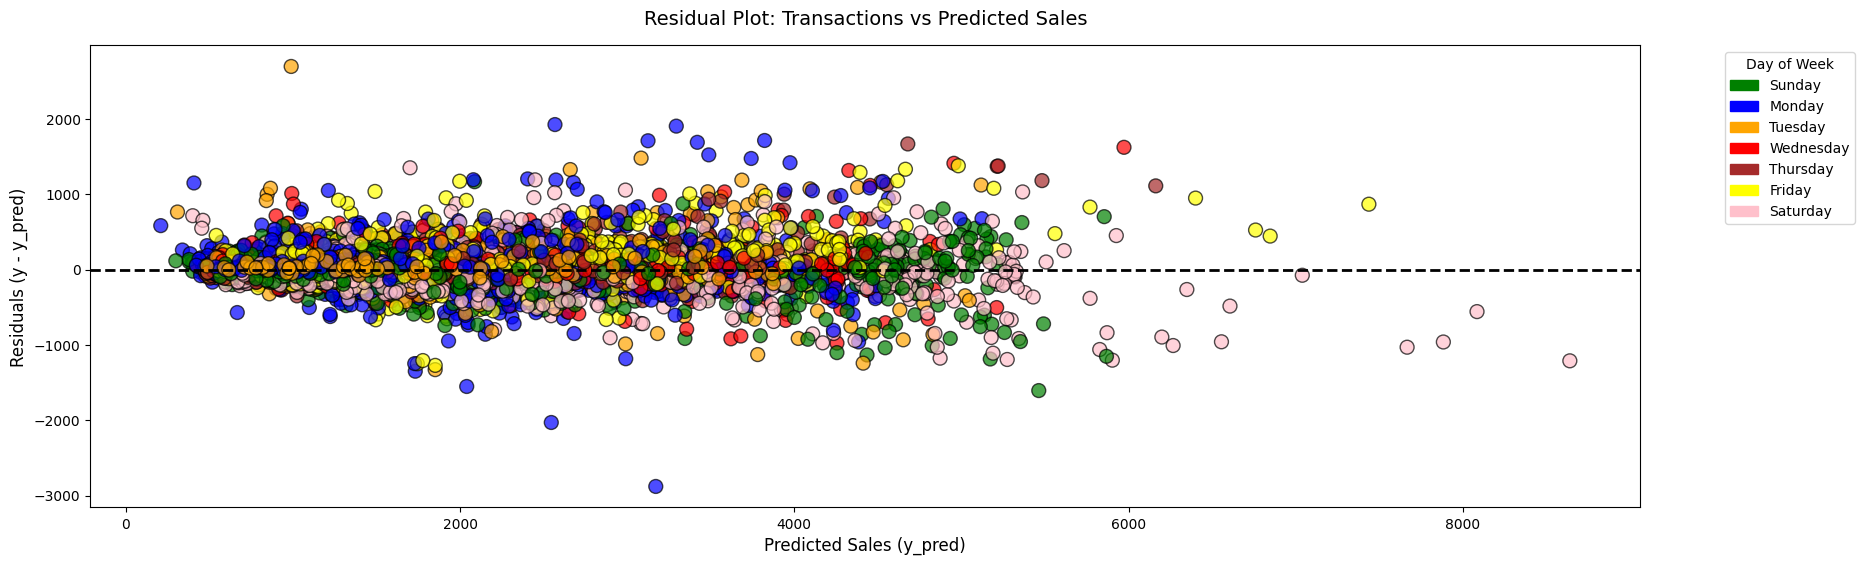

In [427]:
# Plotting
plt.figure(figsize=(20, 6))
# Define color mapping for days
day_colors = {
    'Sunday': 'green', 'Monday': 'blue', 'Tuesday': 'orange',
    'Wednesday': 'red', 'Thursday': 'brown', 'Friday': 'yellow', 'Saturday': 'pink'}
# Scatter plot with two colors based on 'day_cat' (day of the week)
sc = plt.scatter(resid['y_pred'], resid['residuals'], 
                 c=resid['day_cat'].map(day_colors), 
                 s=100, alpha=0.7, edgecolors='k')

# Add a horizontal line at 0 (for residuals)
plt.axhline(0, color='black', lw=2, linestyle='--')

# Labels and title with better spacing
plt.title('Residual Plot: Transactions vs Predicted Sales', fontsize=14, pad=15)
plt.xlabel('Predicted Sales (y_pred)', fontsize=12)
plt.ylabel('Residuals (y - y_pred)', fontsize=12)

# Custom legend
handles = [mpatches.Patch(color=color, label=day) for day, color in day_colors.items()]
plt.legend(handles=handles, title="Day of Week", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [444]:
df.loc[(df['store_nbr'] == "1") & (df['month'] == 12) & (df['day'] == 26)]

date store_nbr  transactions   city      state type cluster  day  \
16532 2013-12-26         1          1980  Quito  Pichincha    D      13   26   
33662 2014-12-26         1          1295  Quito  Pichincha    D      13   26   
51968 2015-12-26         1          1149  Quito  Pichincha    D      13   26   
70967 2016-12-26         1           488  Quito  Pichincha    D      13   26   

       month  year  ... trans_lag  trans_lag_2     day_nbr holiday_type  \
16532     12  2013  ...    2844.0       2848.0  Thursday_1   Additional   
33662     12  2014  ...    2800.0       2861.0    Friday_1   Additional   
51968     12  2015  ...    2775.0       2833.0  Saturday_1   Additional   
70967     12  2016  ...    1993.0       3023.0    Monday_1   Additional   

         locale locale_name holiday_name transferred is_holiday  \
16532  National     Ecuador    Navidad+1       False    holiday   
33662  National     Ecuador    Navidad+1       False    holiday   
51968  National     Ecuador    Navidad+1       False    holiday   
70967  National     Ecuador    Navidad+1       False    holiday   

      store_day_interaction  
16532    1_Thursday_holiday  
33662      1_Friday_holiday  
51968    1_Saturday_holiday  
70967      1_Monday_holiday  

[4 rows x 21 columns]

<Axes: xlabel='date'>

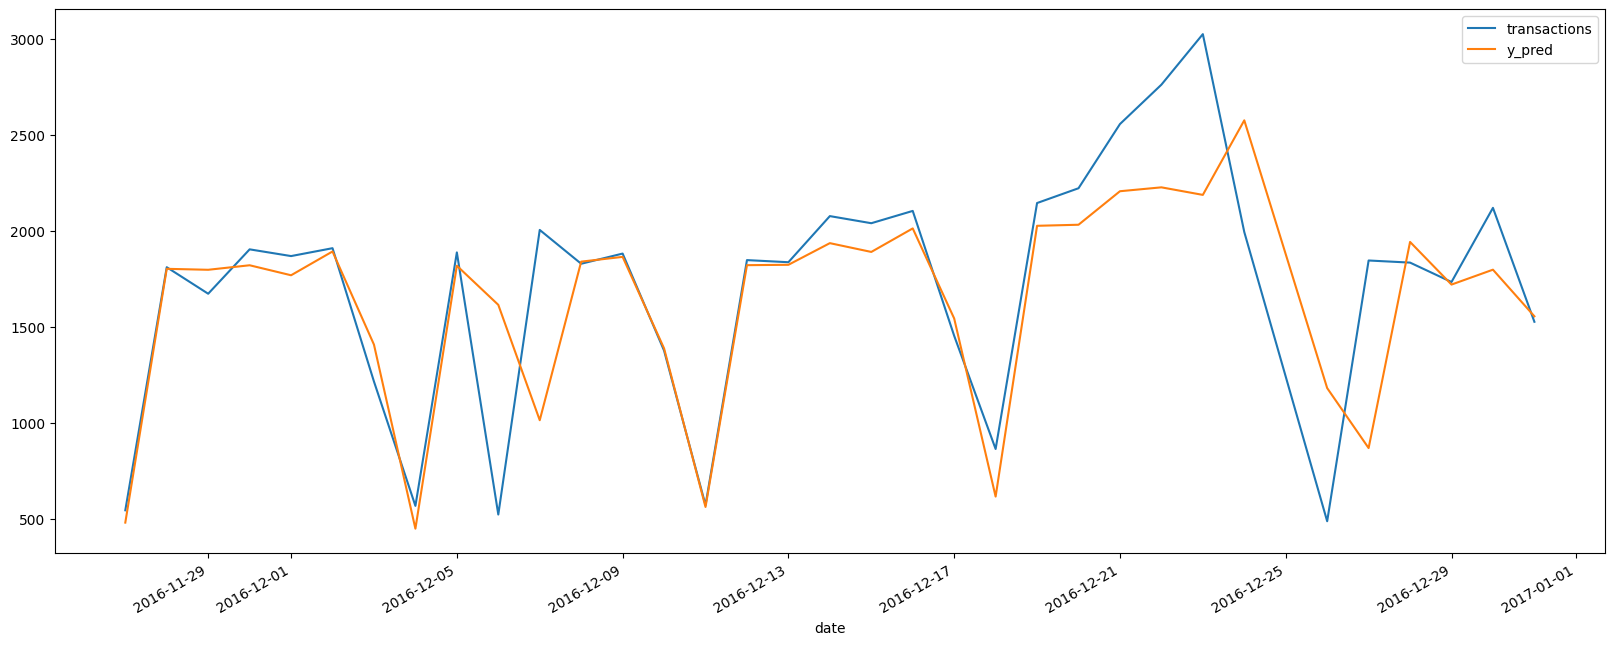

In [445]:
resid.loc[(df['store_nbr'] == "1") & (df['year'] == 2016)].set_index('date')[['transactions', 'y_pred']].plot(figsize = (20,8))

In [446]:
resid.sort_values(by = 'residuals').head(10)

date store_nbr  transactions     city        state type cluster  \
76153 2017-04-03        45           292    Quito    Pichincha    A      11   
76099 2017-04-02        44          3857    Quito    Pichincha    A       5   
70885 2016-12-23        25          1296  Salinas  Santa Elena    D       1   
77602 2017-05-01         1           481    Quito    Pichincha    D      13   
77701 2017-05-02        46          3170    Quito    Pichincha    A      14   
79051 2017-05-27        46          4081    Quito    Pichincha    A      14   
71276 2016-12-31        45          4701    Quito    Pichincha    A      11   
73873 2017-02-19        44          3986    Quito    Pichincha    A       5   
83209 2017-08-12        46          3697    Quito    Pichincha    A      14   
78347 2017-05-14        44          4717    Quito    Pichincha    A       5   

       day  month  year  ...      day_nbr  holiday_type    locale locale_name  \
76153    3      4  2017  ...    Monday_45           NaN       NaN         NaN   
76099    2      4  2017  ...    Sunday_44           NaN       NaN         NaN   
70885   23     12  2016  ...    Friday_25    Additional  National     Ecuador   
77602    1      5  2017  ...     Monday_1           NaN       NaN         NaN   
77701    2      5  2017  ...   Tuesday_46           NaN       NaN         NaN   
79051   27      5  2017  ...  Saturday_46           NaN       NaN         NaN   
71276   31     12  2016  ...  Saturday_45           NaN       NaN         NaN   
73873   19      2  2017  ...    Sunday_44           NaN       NaN         NaN   
83209   12      8  2017  ...  Saturday_46           NaN       NaN         NaN   
78347   14      5  2017  ...    Sunday_44           NaN       NaN         NaN   

      holiday_name transferred   is_holiday    store_day_interaction  \
76153   no_holiday         NaN  not_holiday    45_Monday_not_holiday   
76099   no_holiday         NaN  not_holiday    44_Sunday_not_holiday   
70885    Navidad-2       False      holiday        25_Friday_holiday   
77602   no_holiday         NaN  not_holiday     1_Monday_not_holiday   
77701   no_holiday         NaN  not_holiday   46_Tuesday_not_holiday   
79051   no_holiday         NaN  not_holiday  46_Saturday_not_holiday   
71276   no_holiday         NaN  not_holiday  45_Saturday_not_holiday   
73873   no_holiday         NaN  not_holiday    44_Sunday_not_holiday   
83209   no_holiday         NaN  not_holiday  46_Saturday_not_holiday   
78347   no_holiday         NaN  not_holiday    44_Sunday_not_holiday   

            y_pred    residuals  
76153  3136.356631 -2844.356631  
76099  5456.039643 -1599.039643  
70885  2585.863966 -1289.863966  
77602  1768.676470 -1287.676470  
77701  4370.272696 -1200.272696  
79051  5270.992660 -1189.992660  
71276  5890.243008 -1189.243008  
73873  5168.996745 -1182.996745  
83209  4873.764591 -1176.764591  
78347  5856.776795 -1139.776795  

[10 rows x 23 columns]

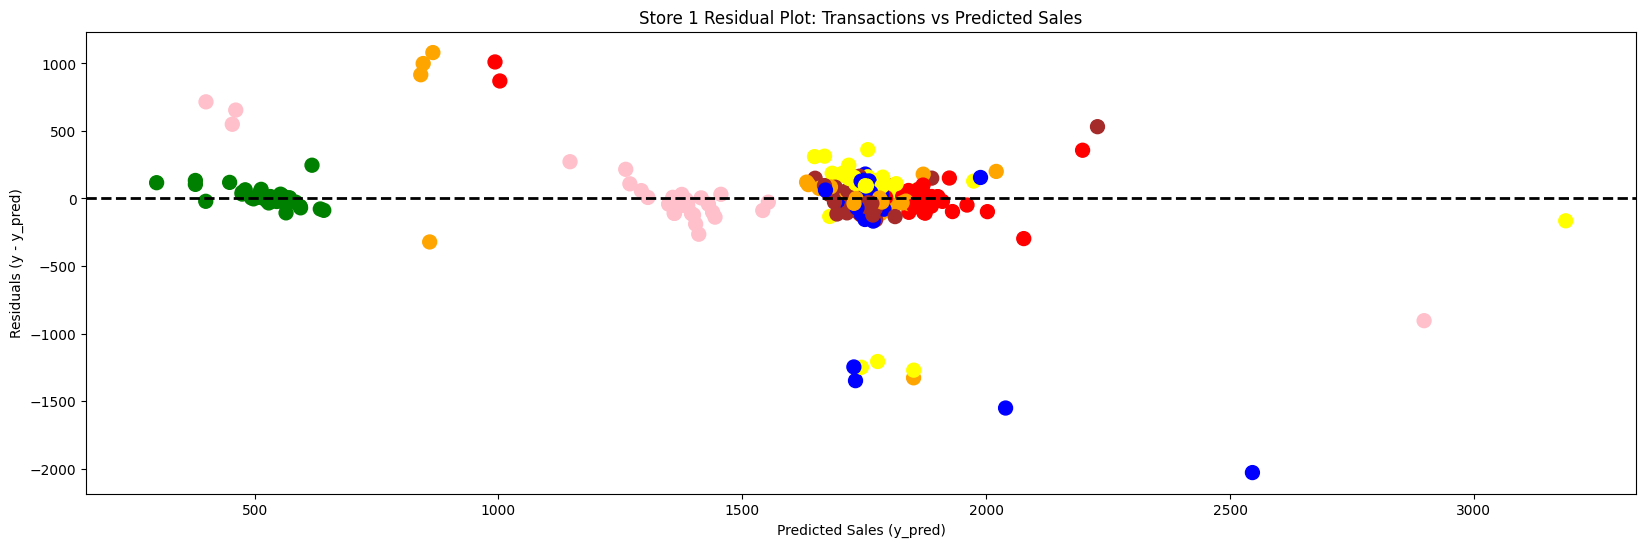

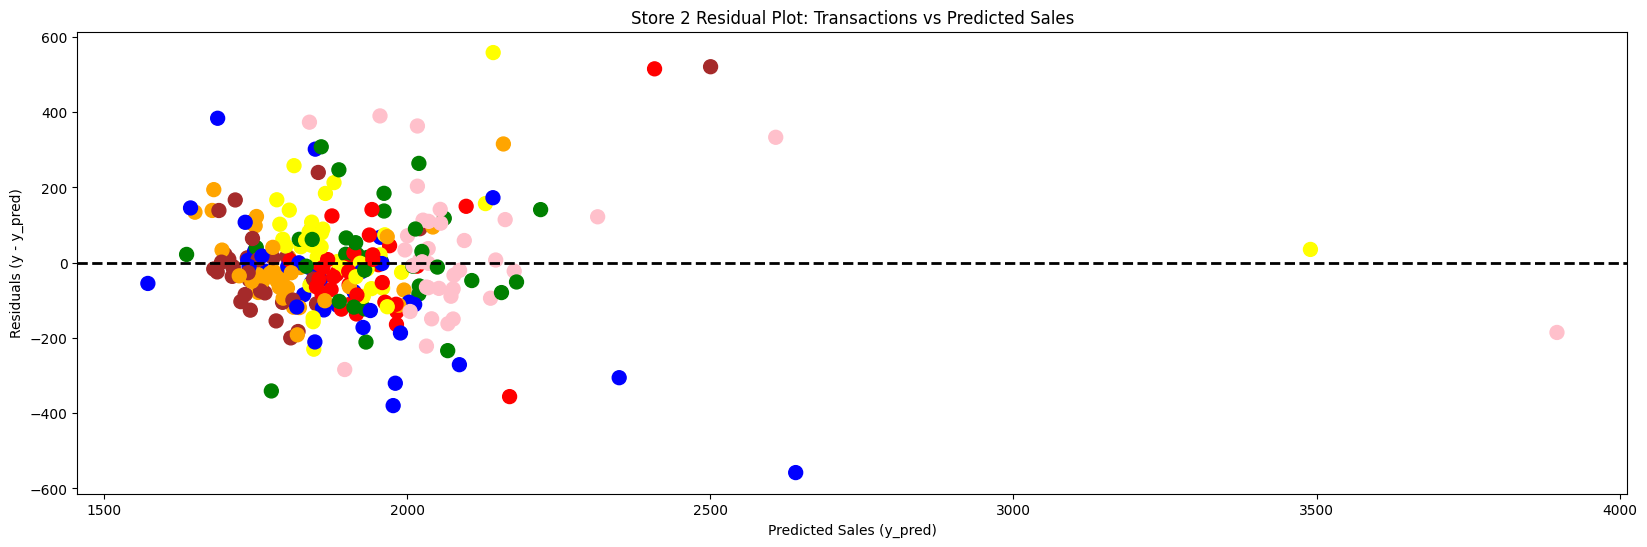

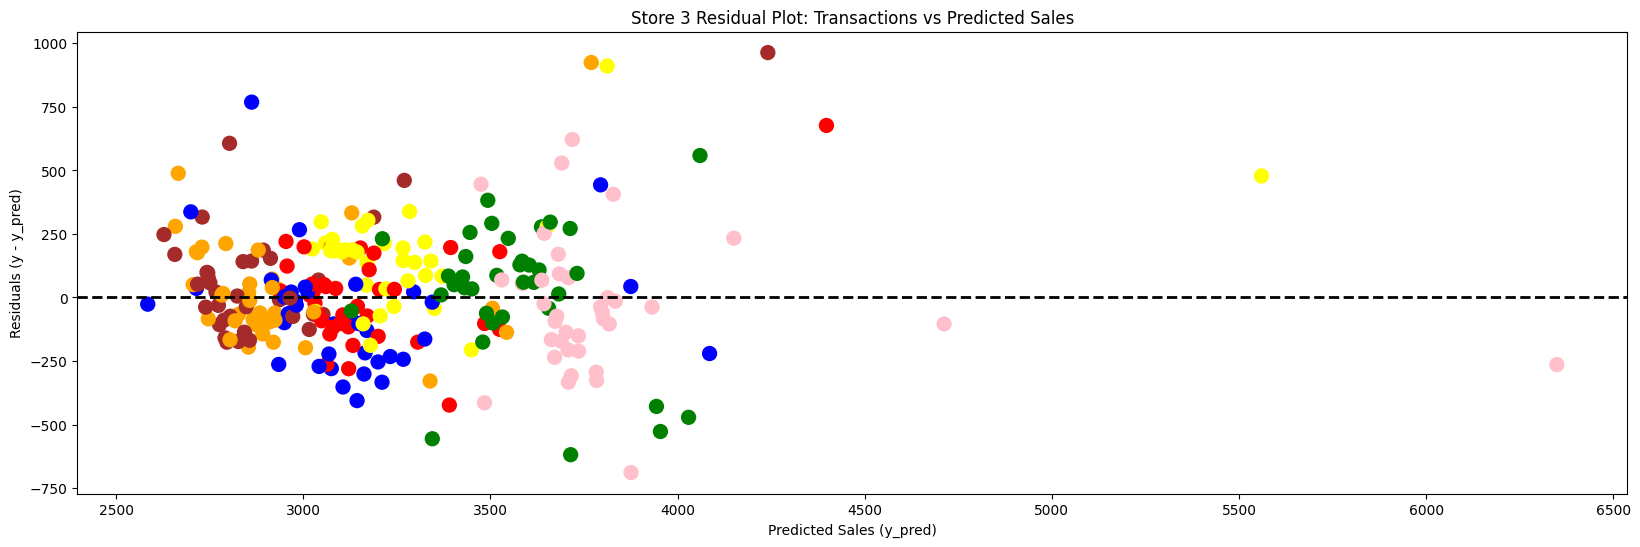

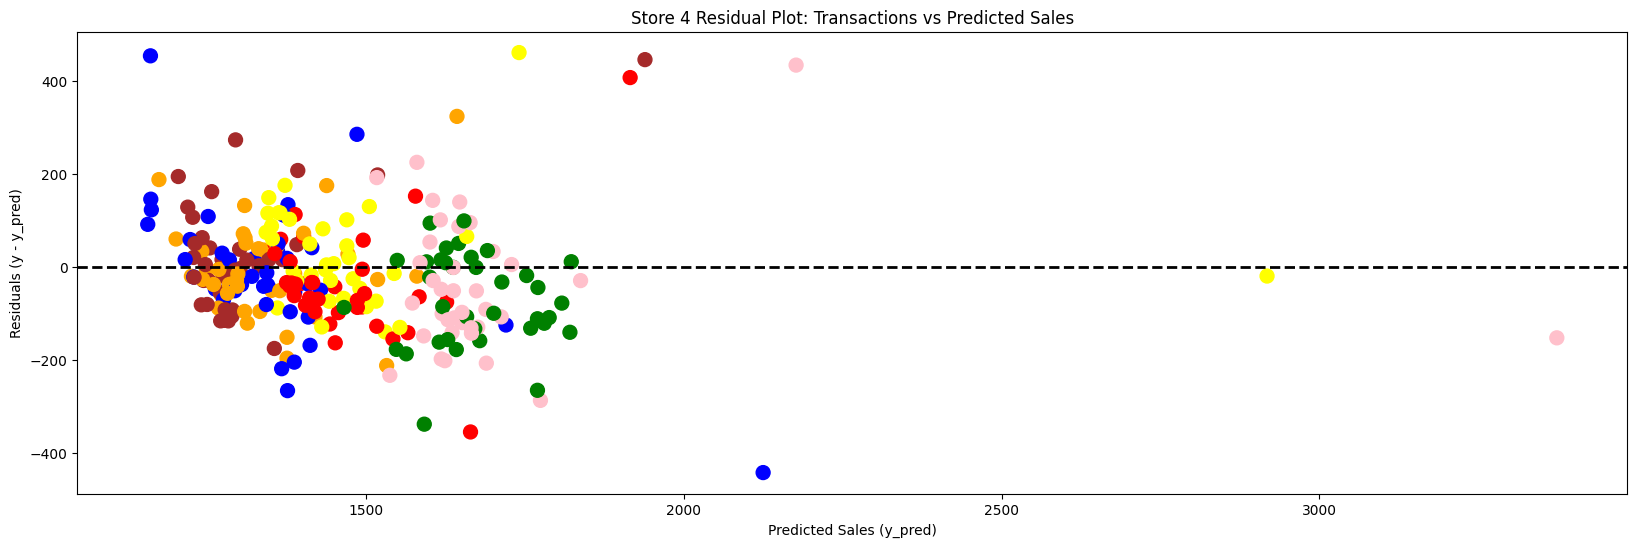

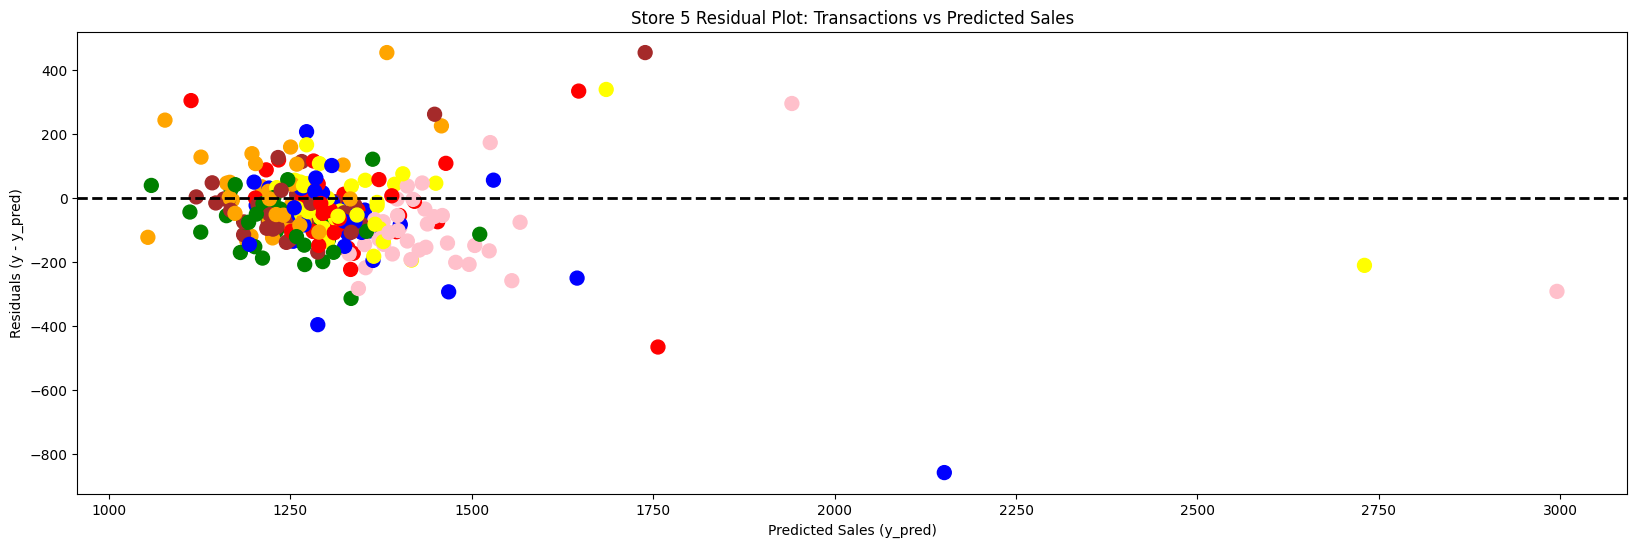

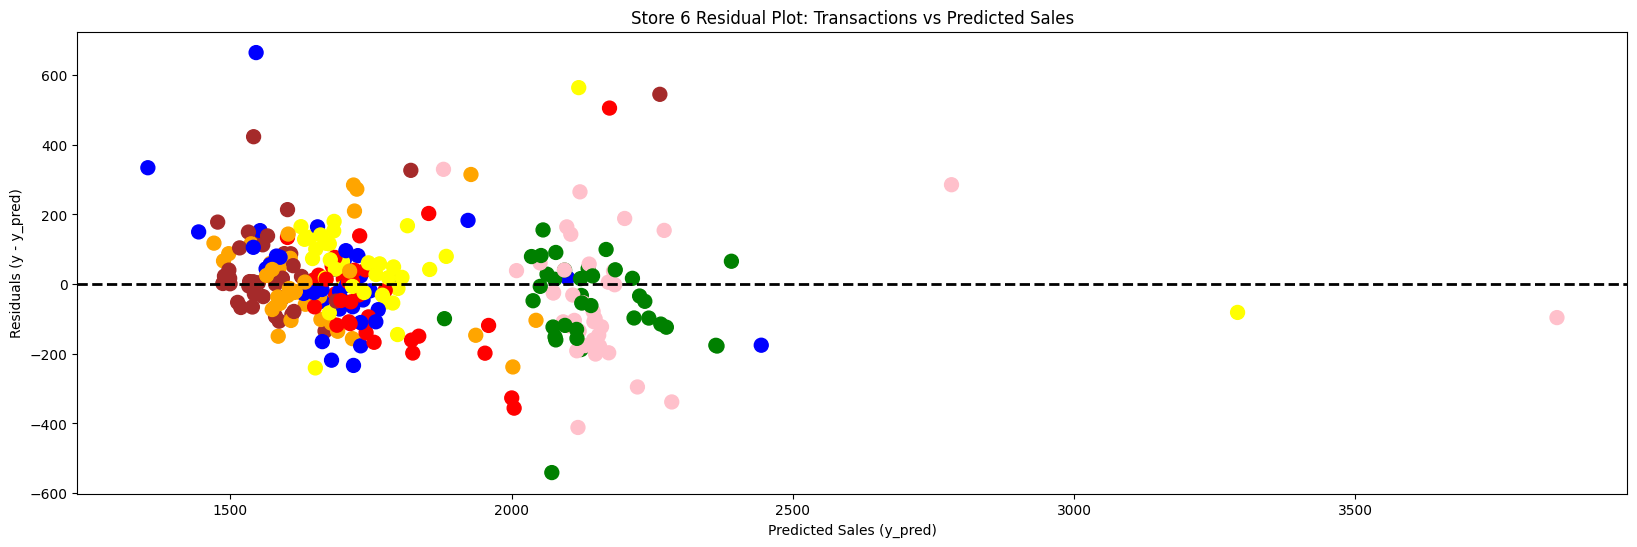

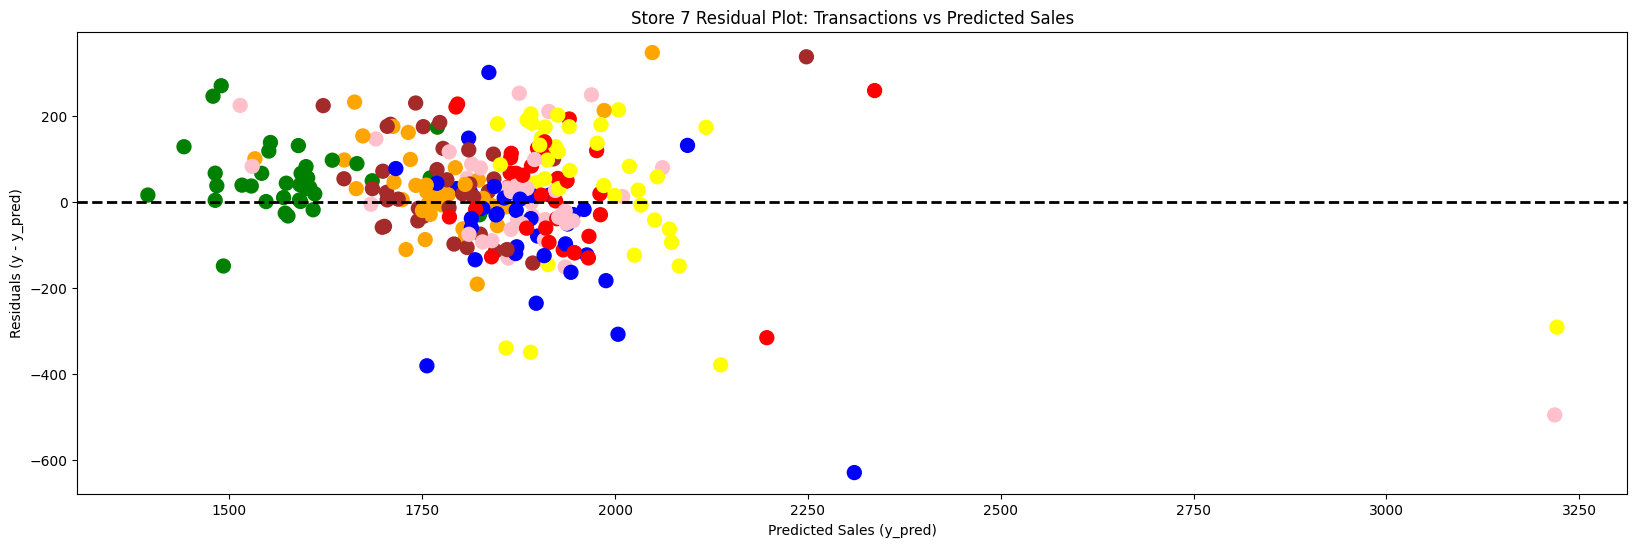

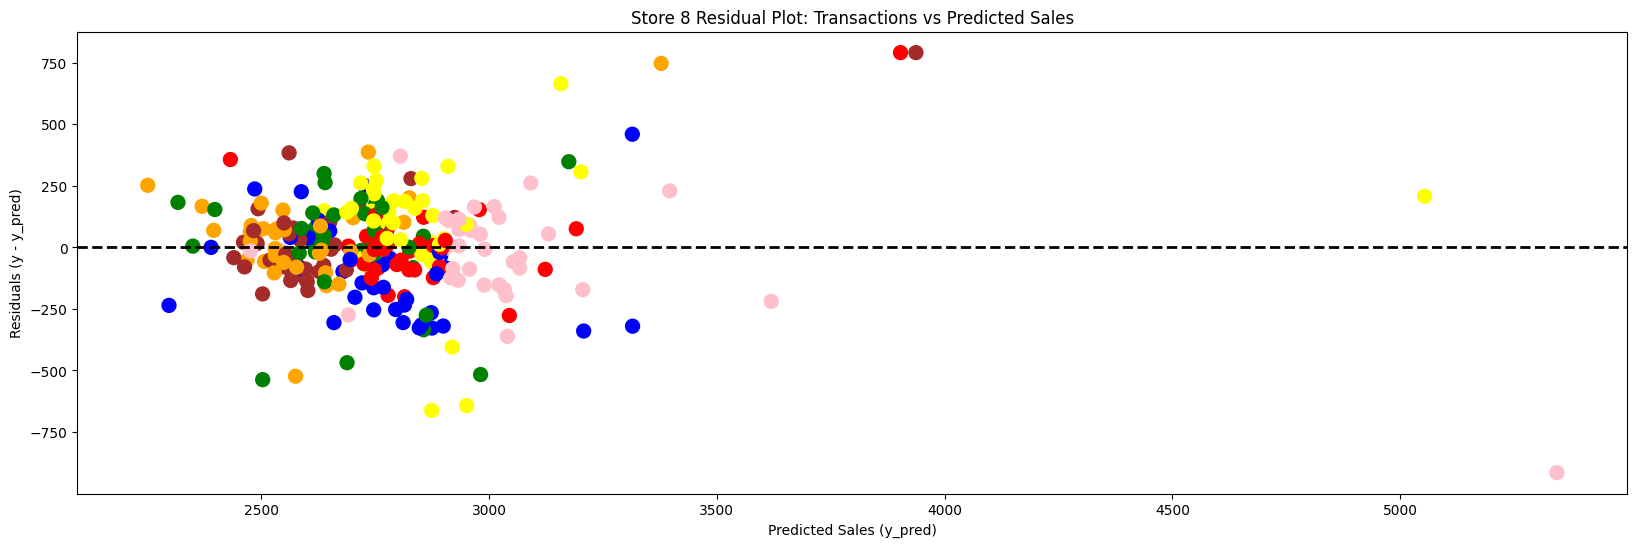

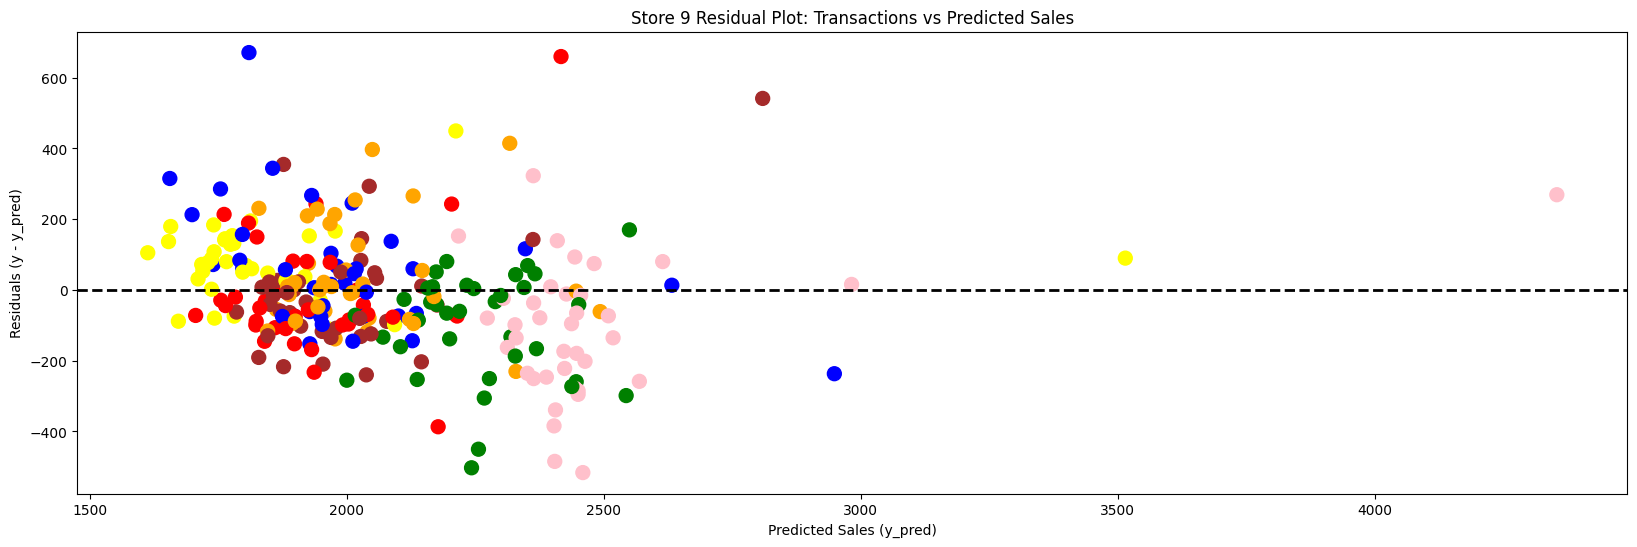

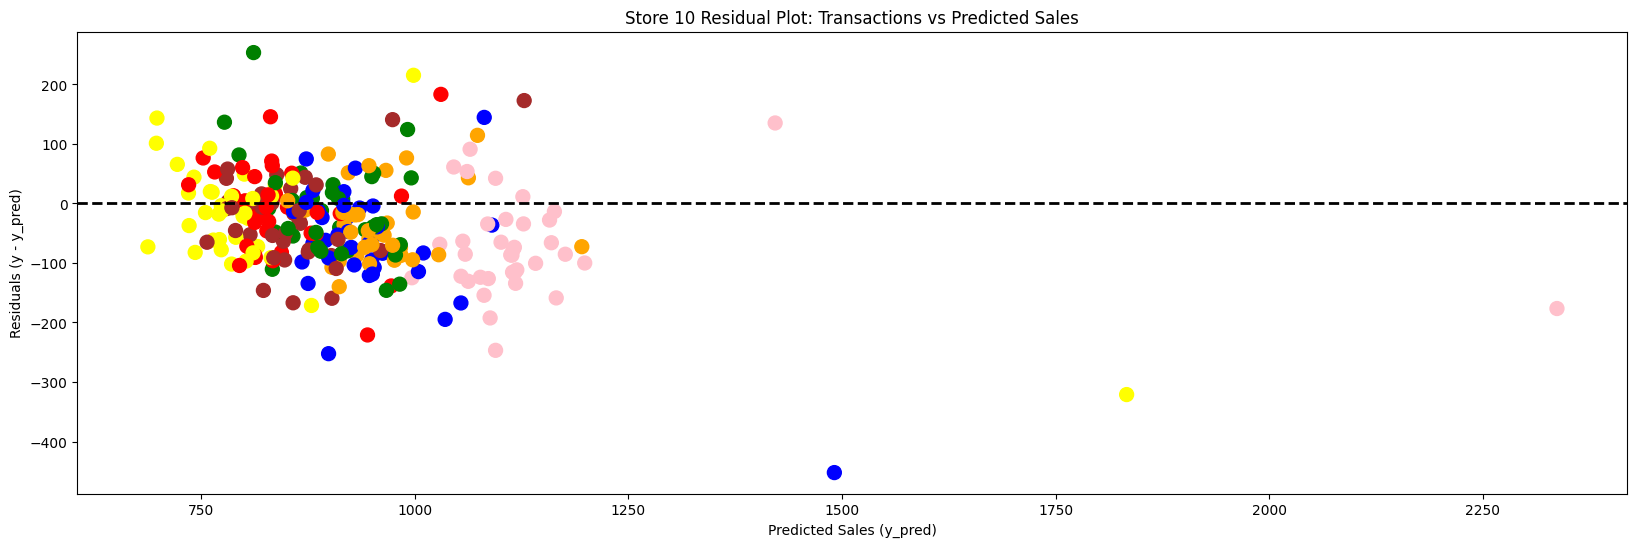

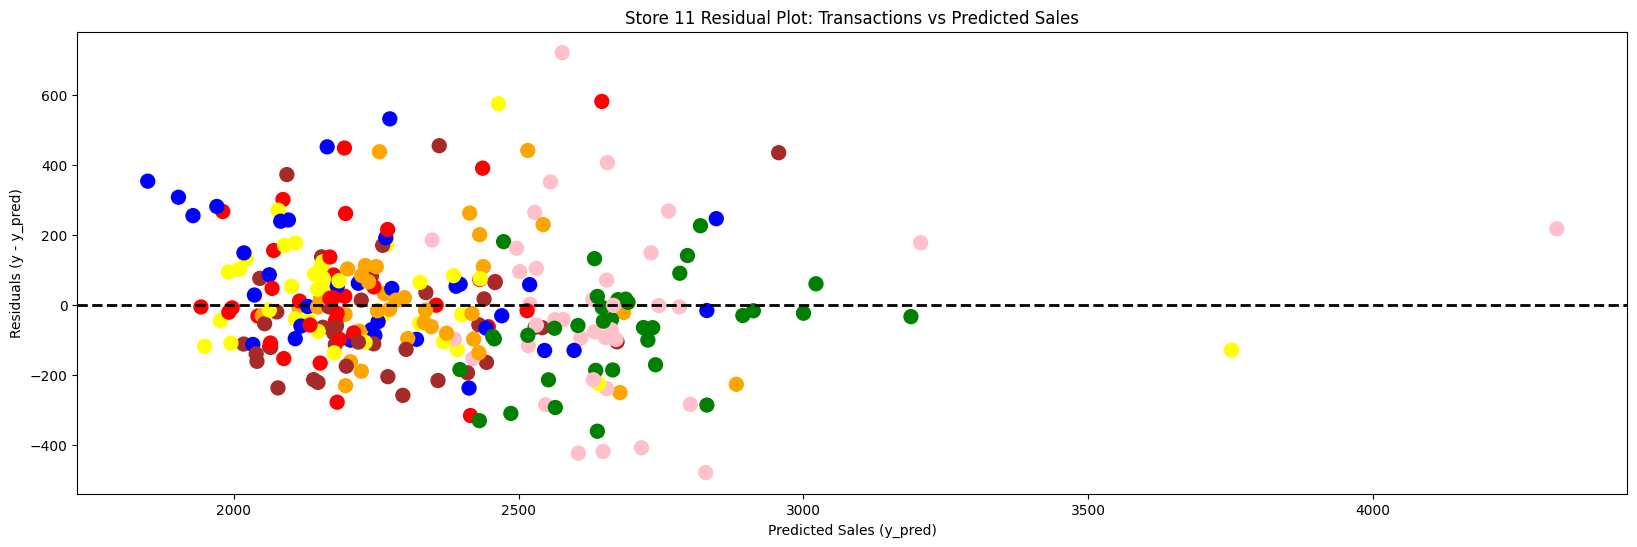

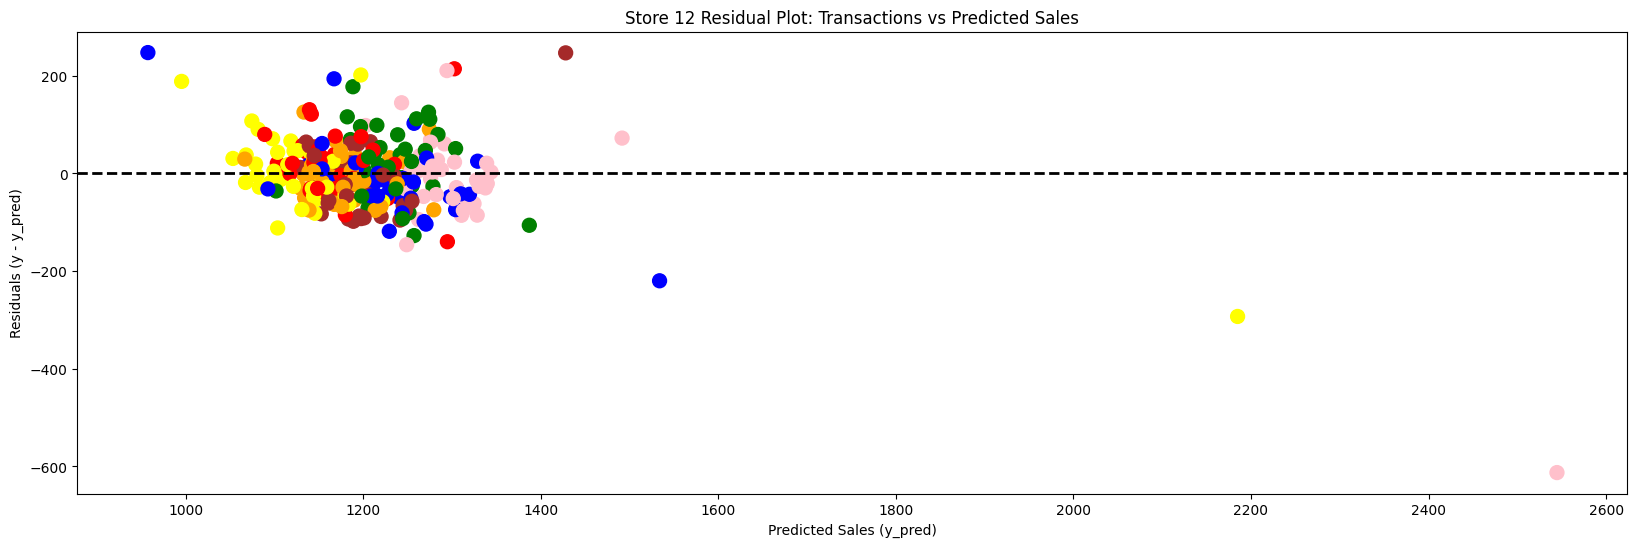

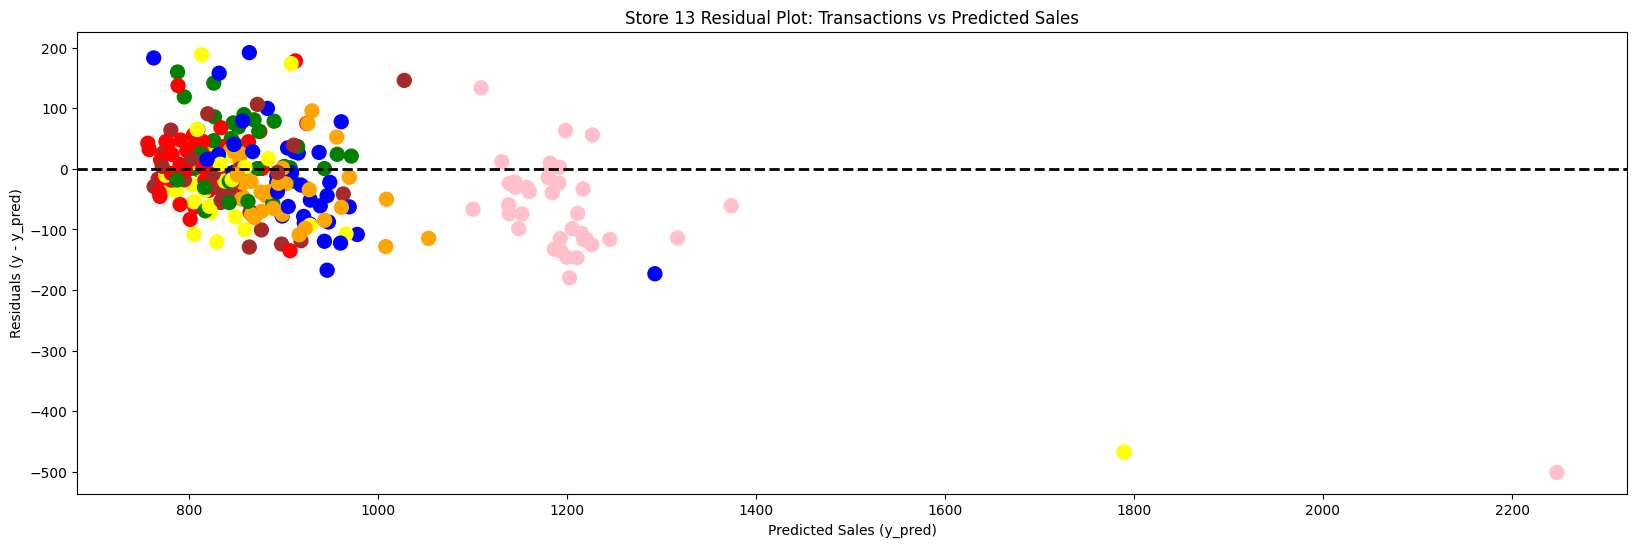

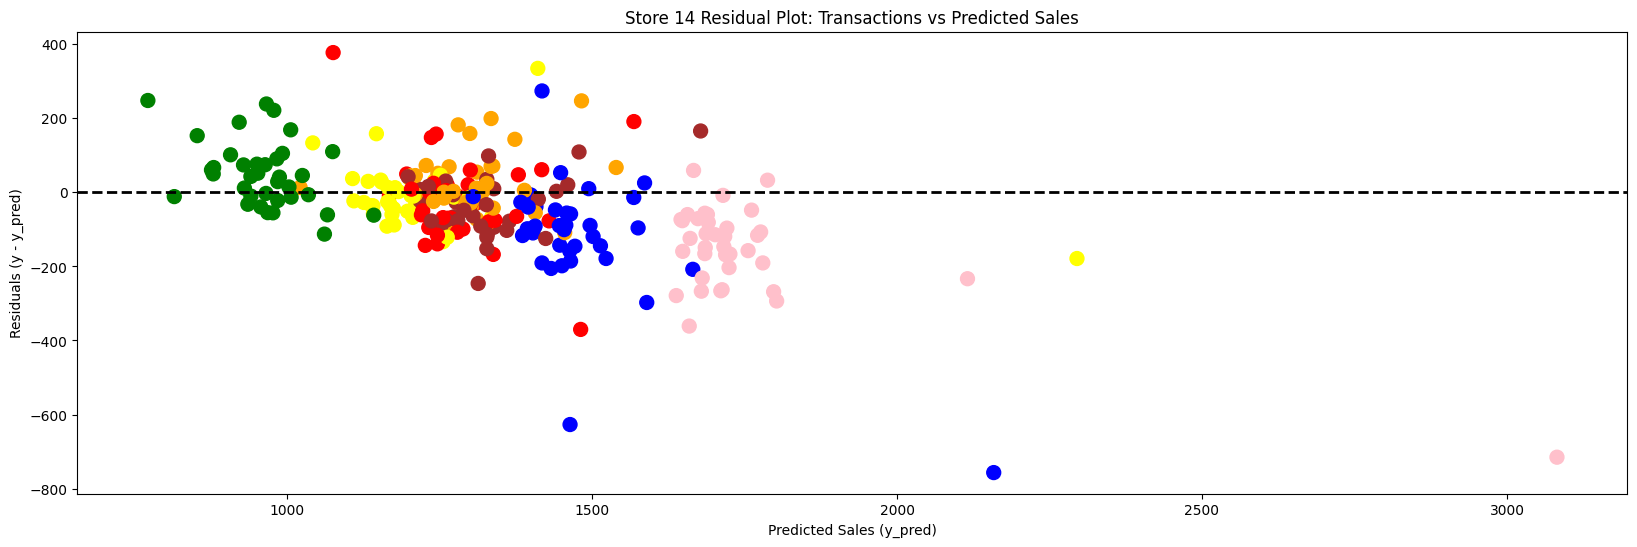

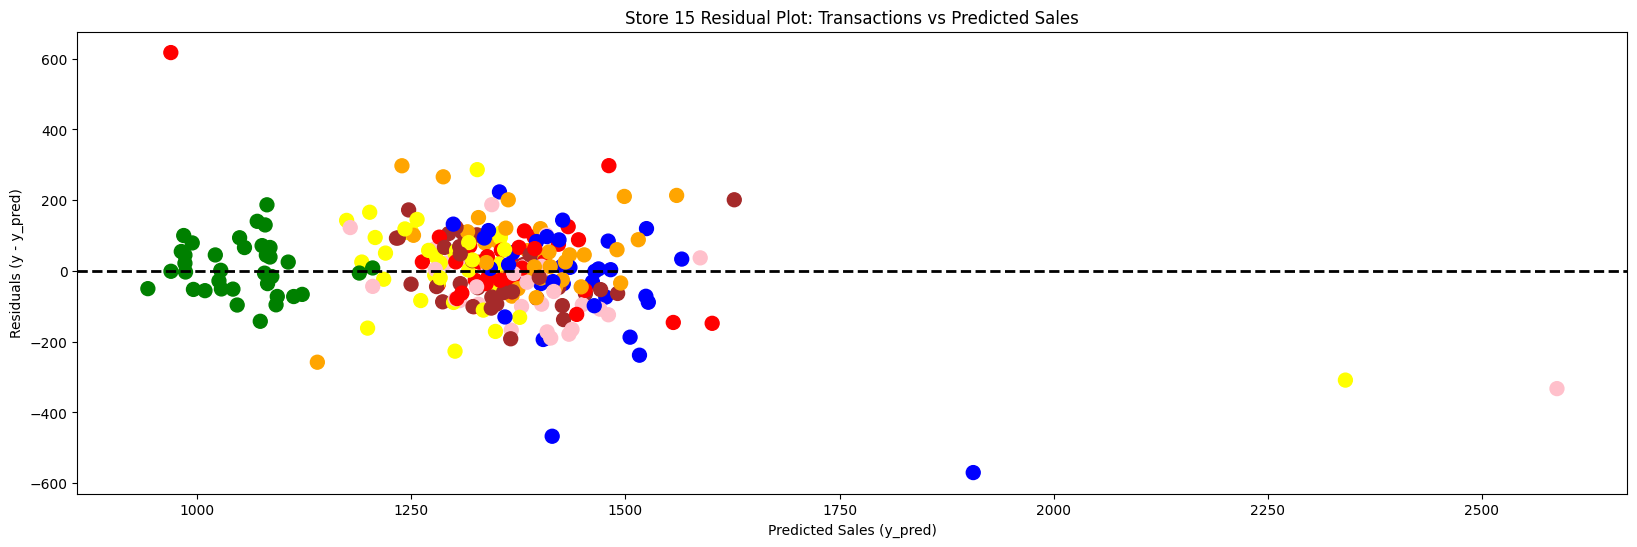

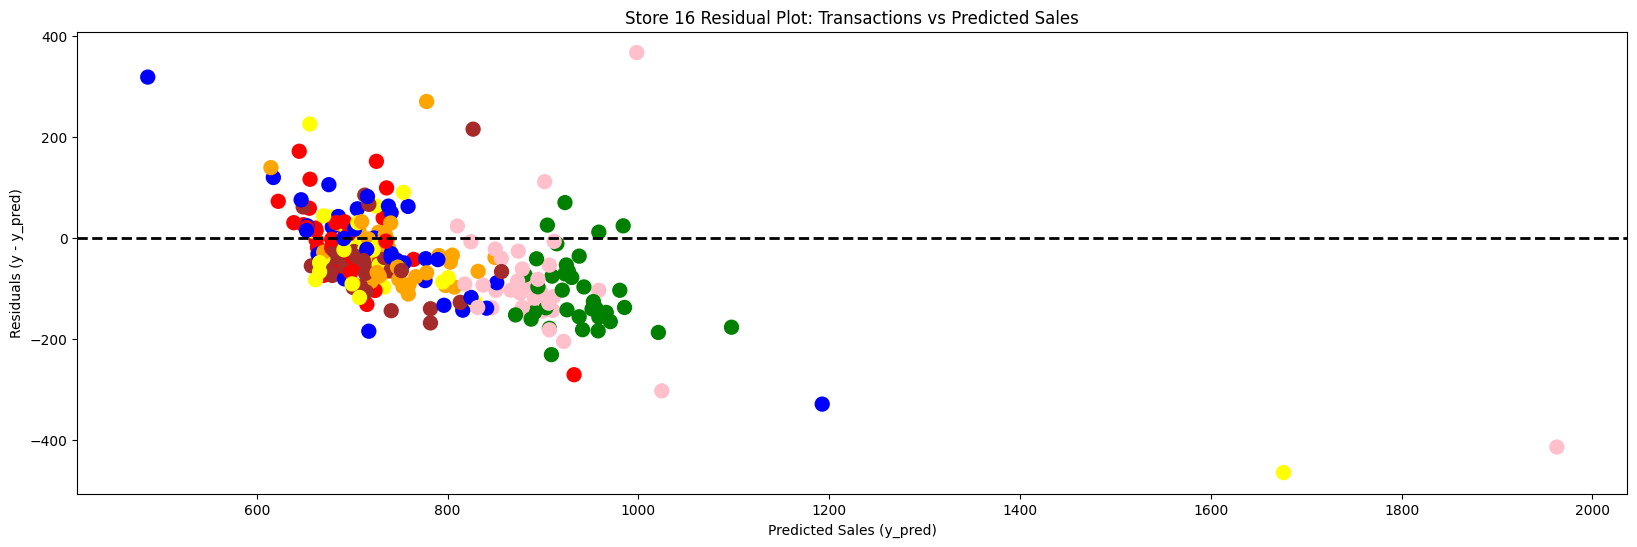

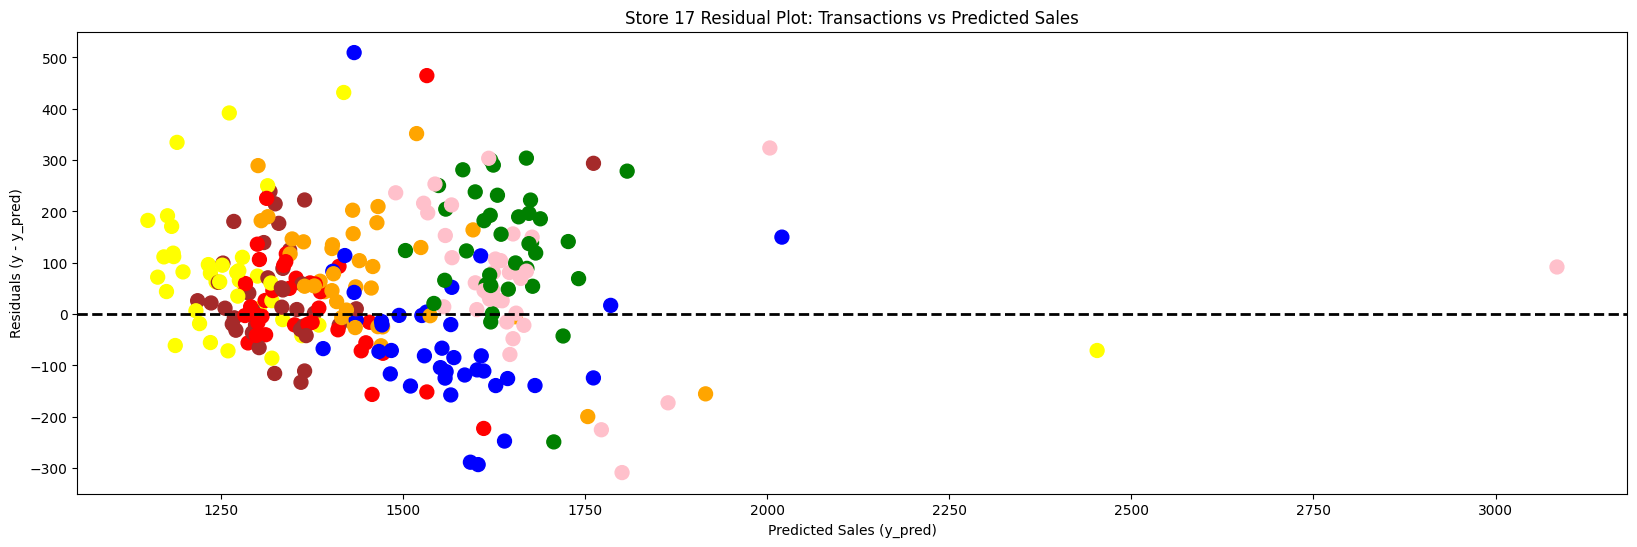

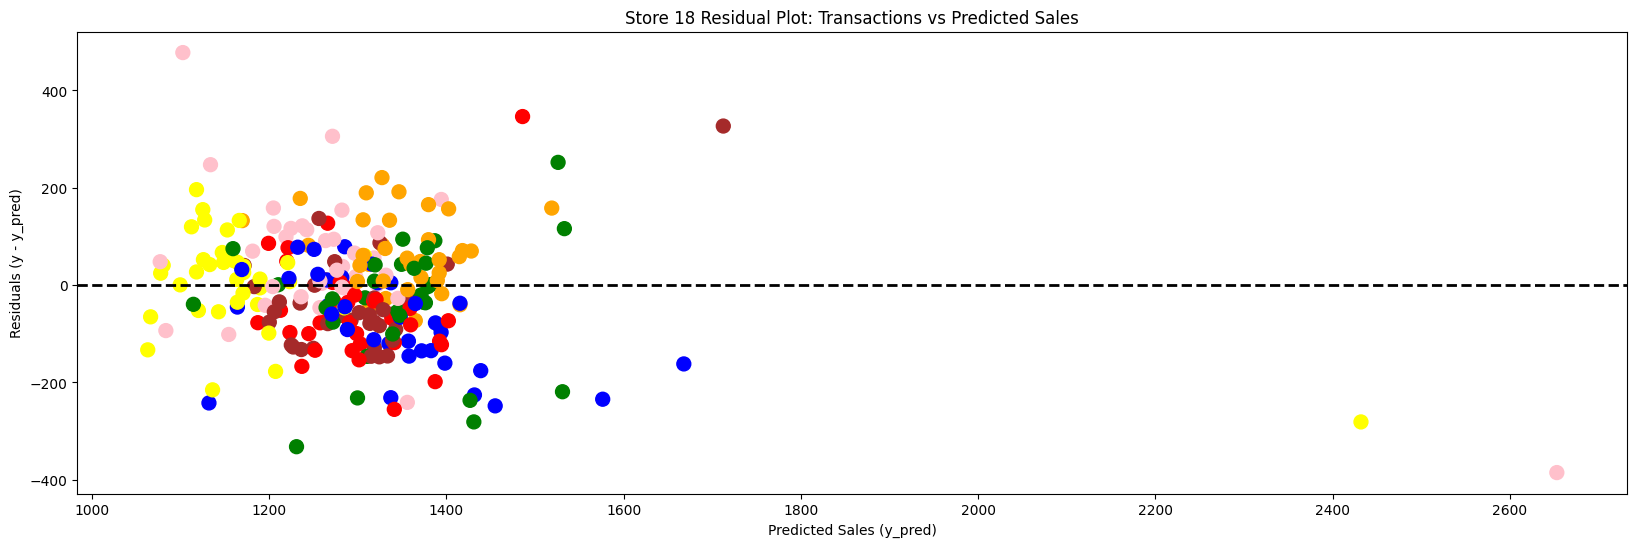

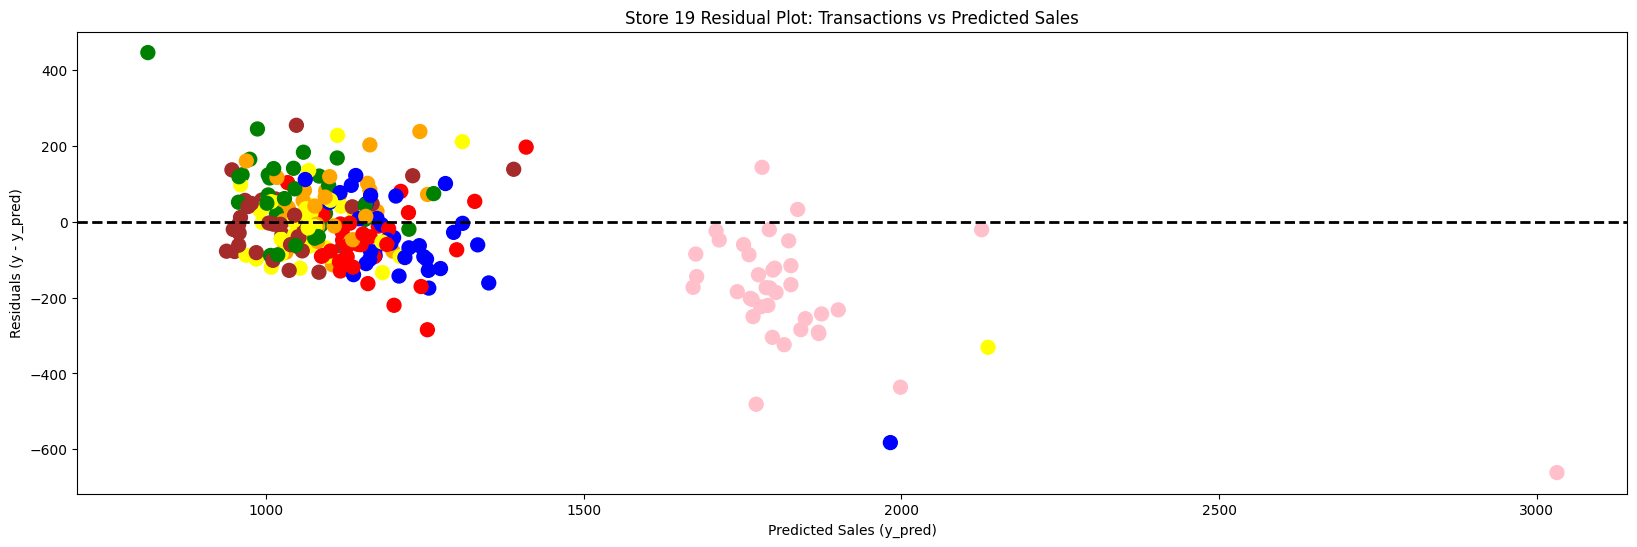

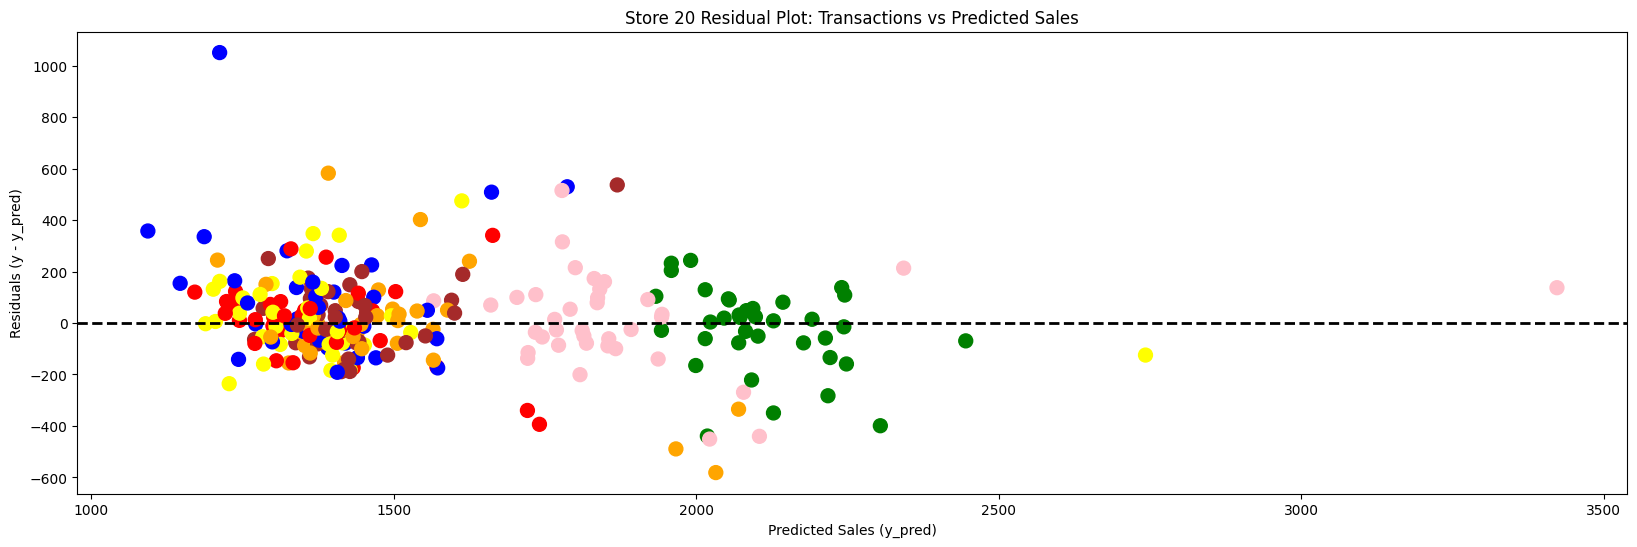

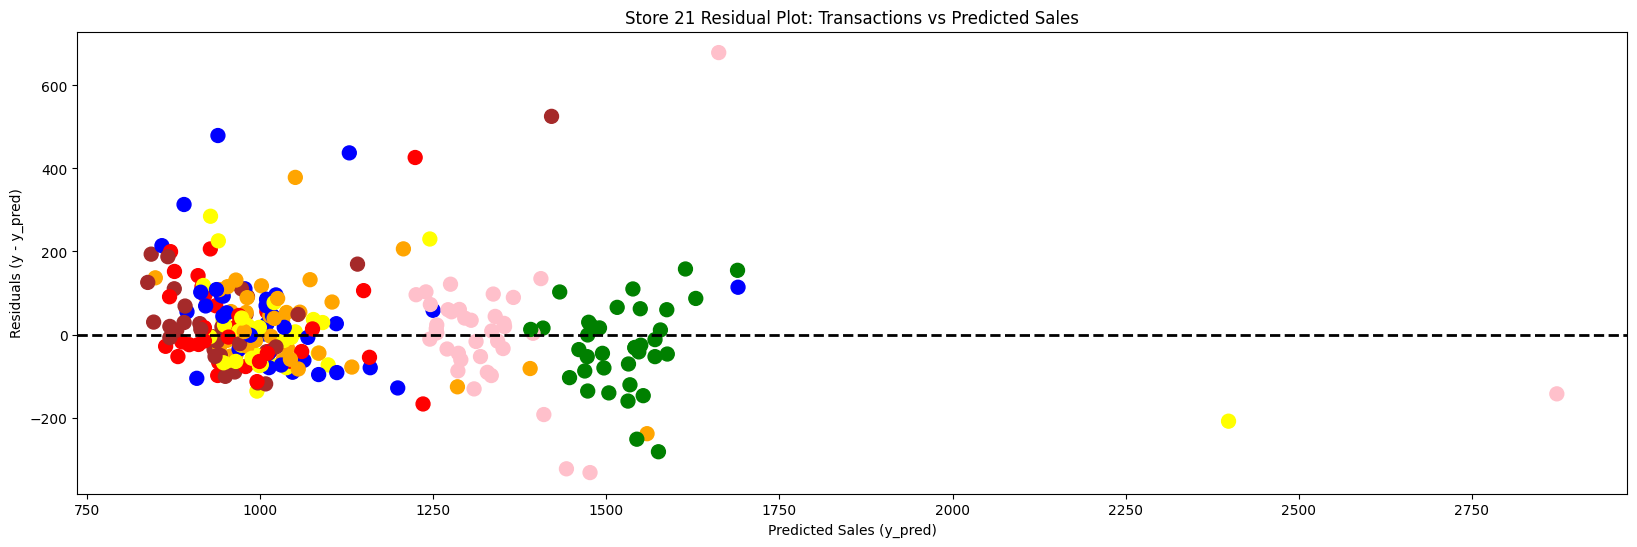

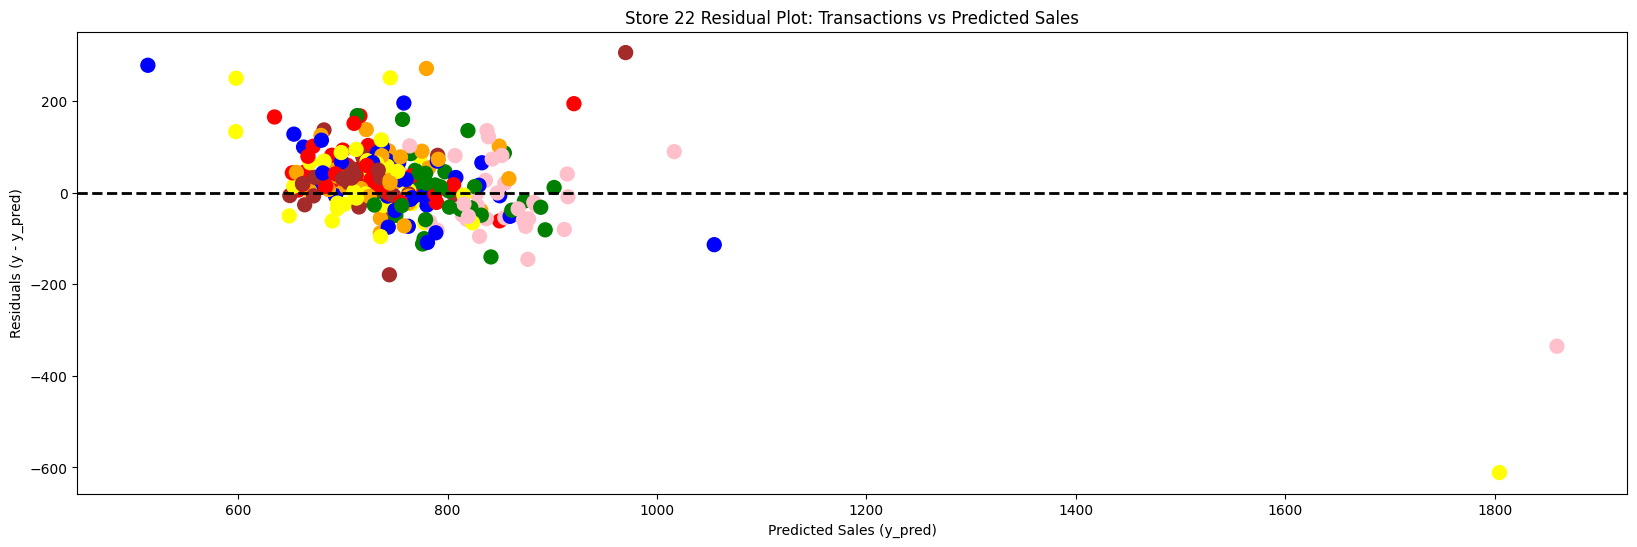

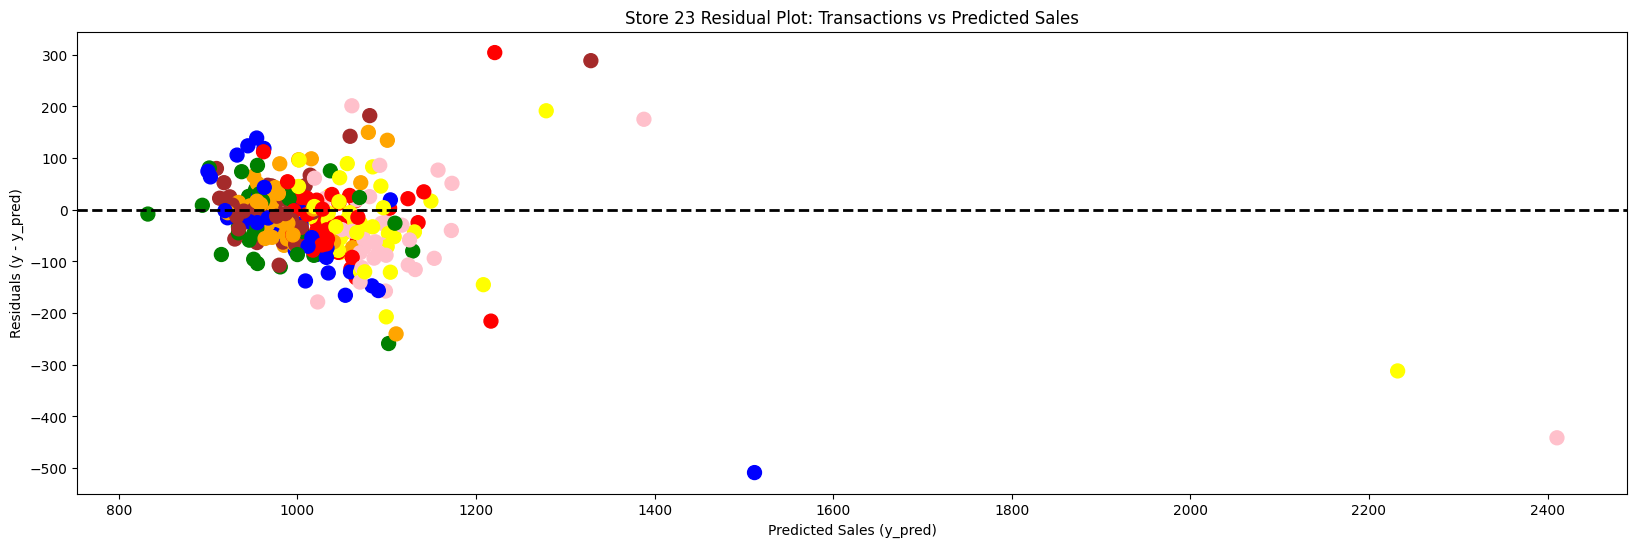

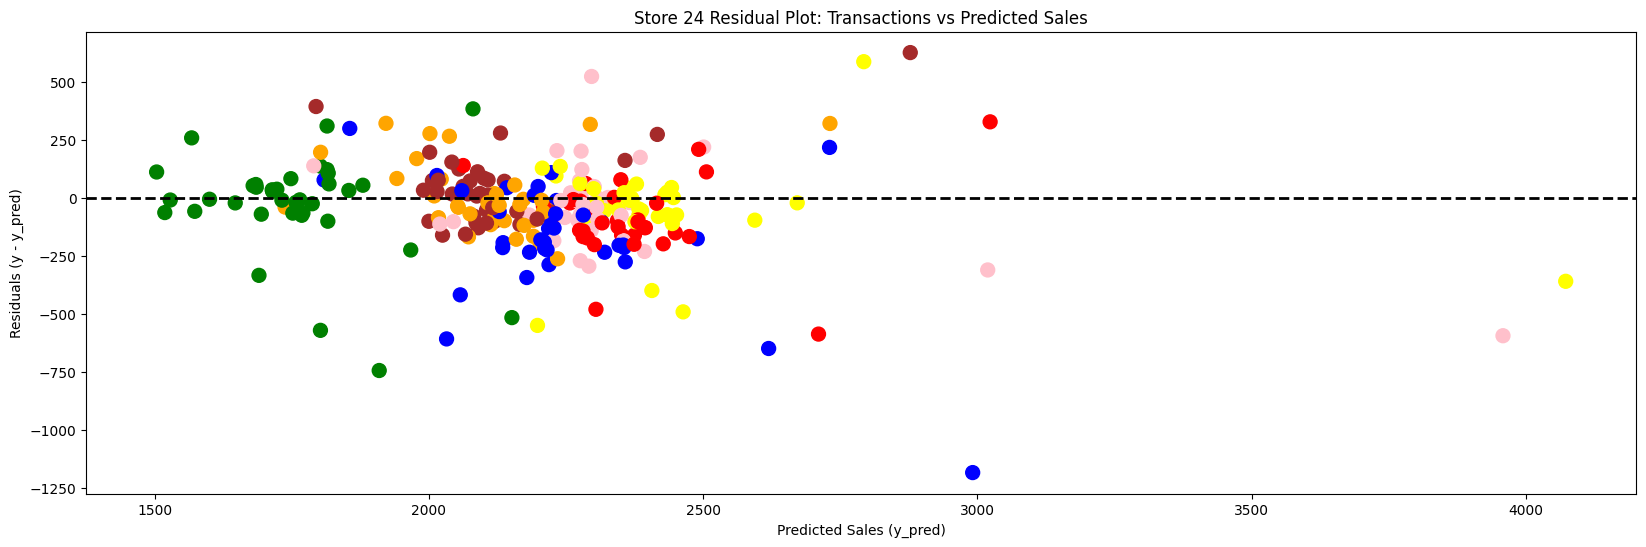

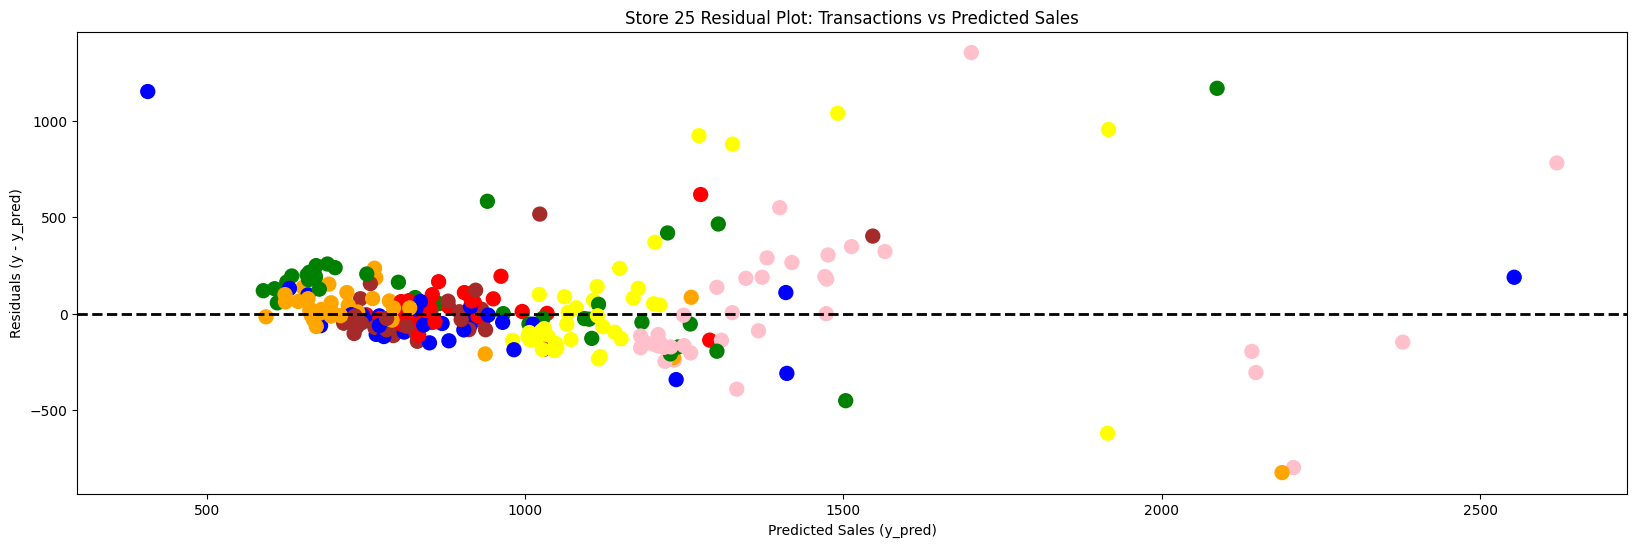

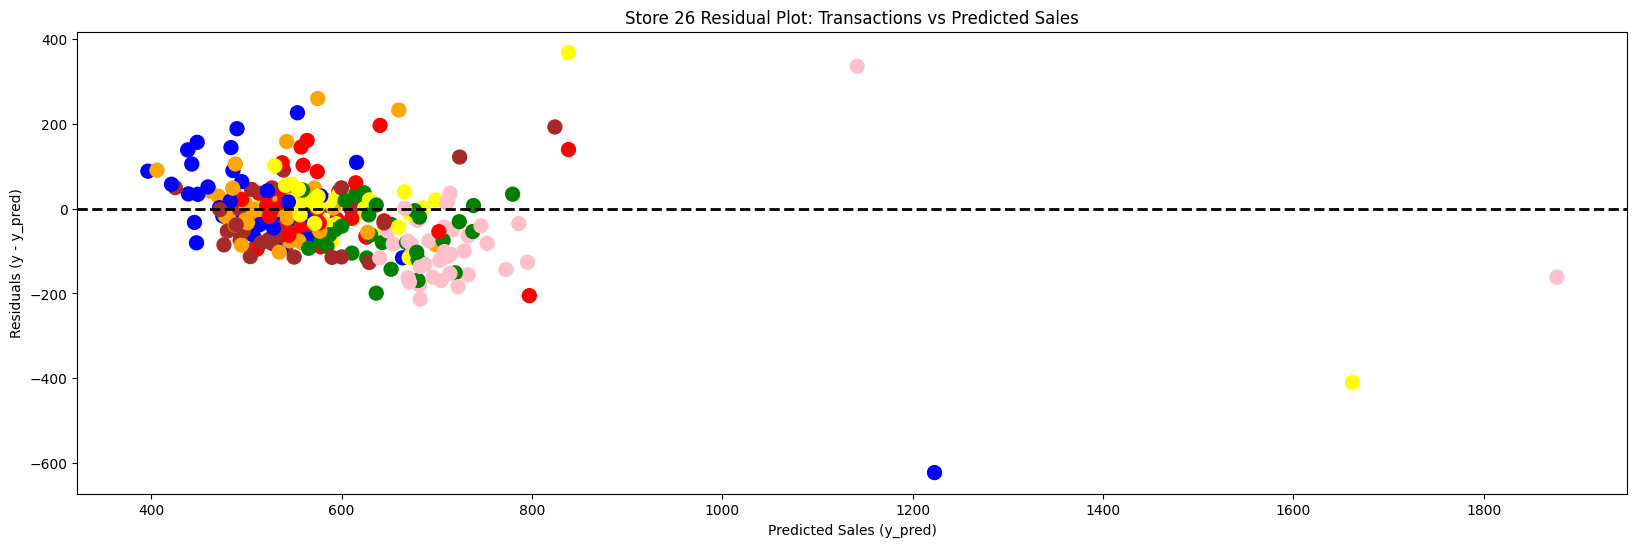

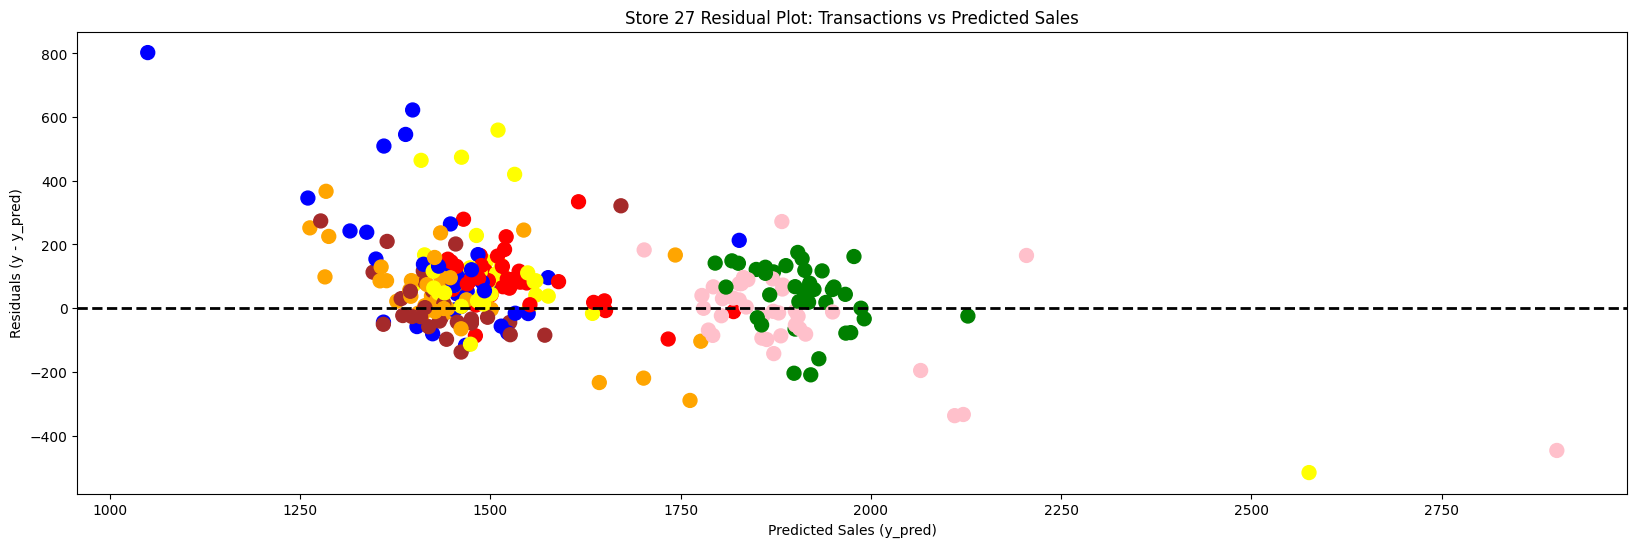

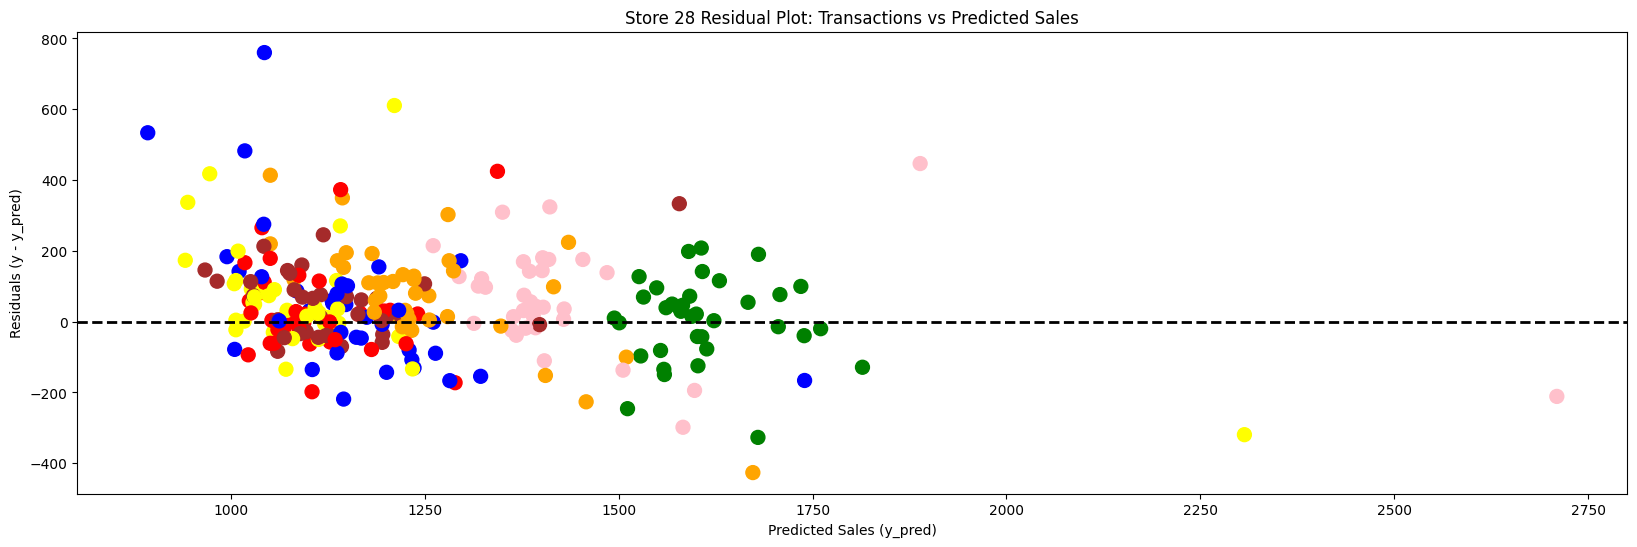

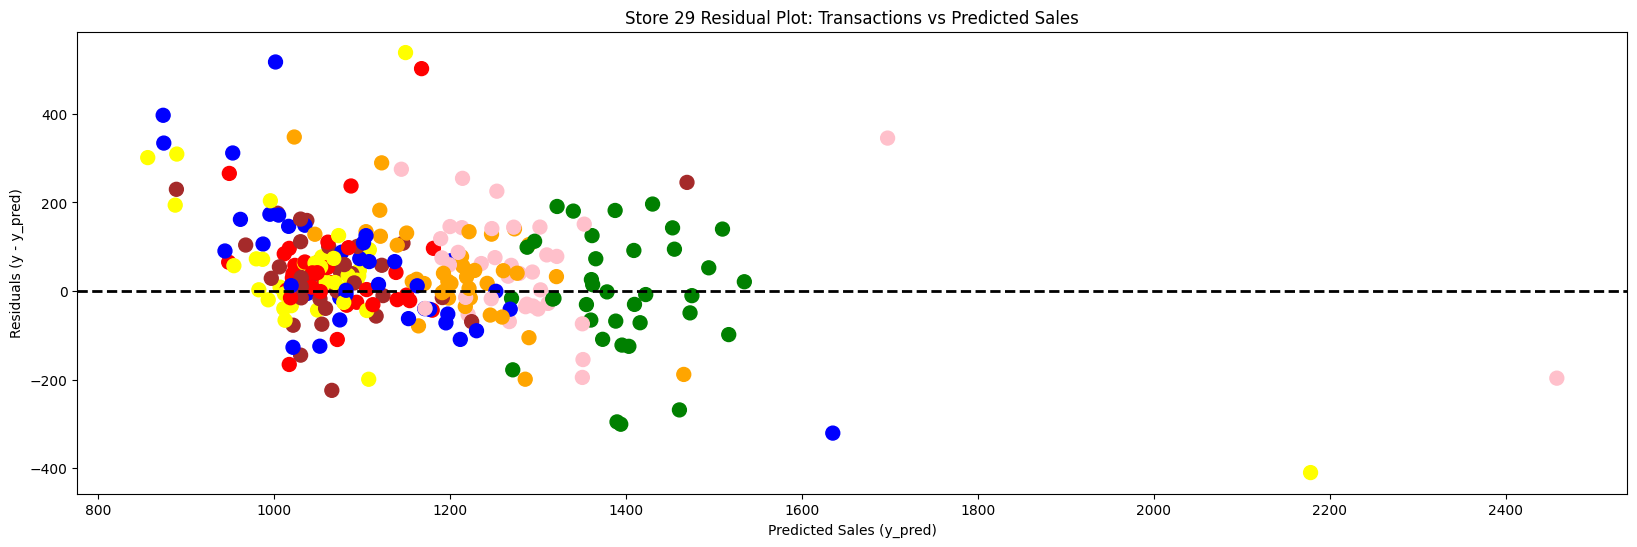

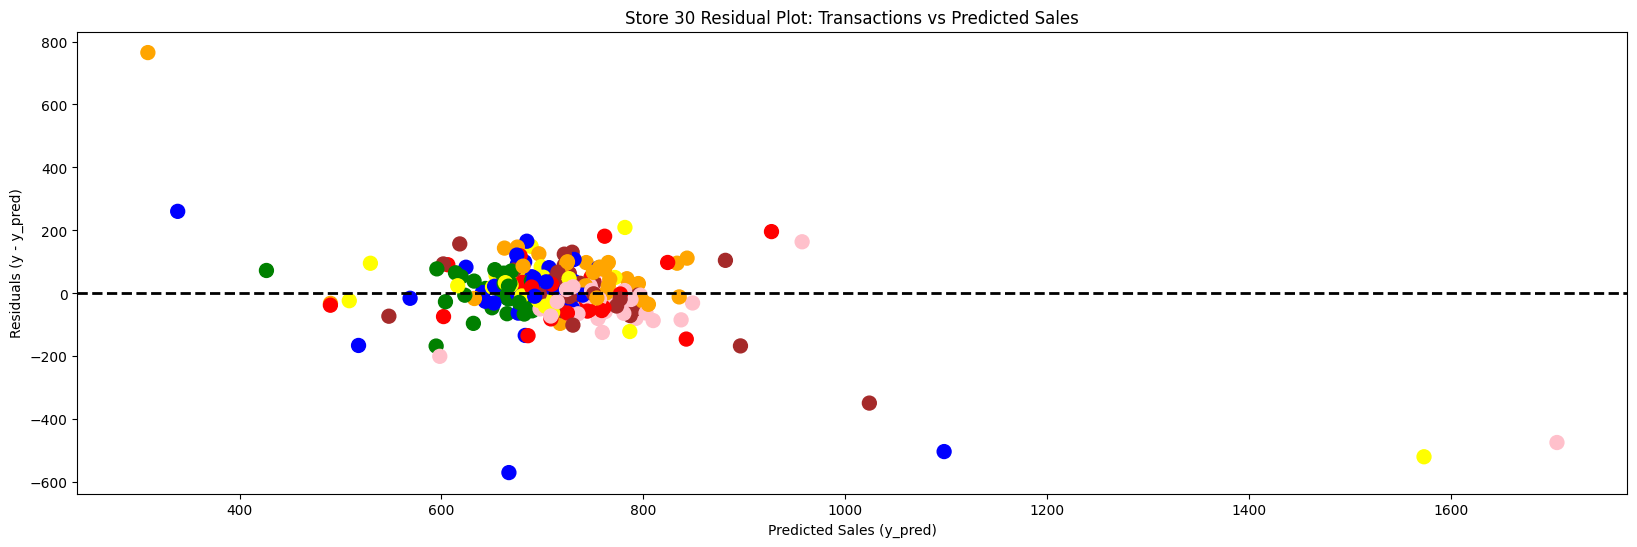

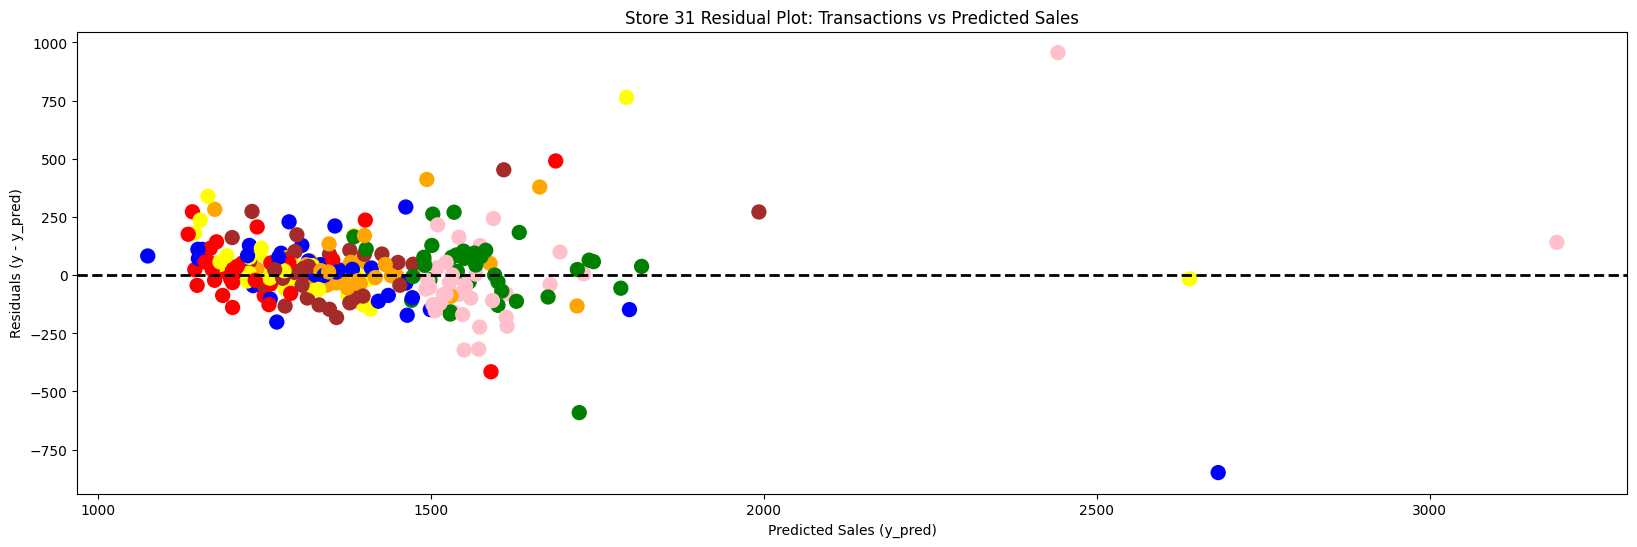

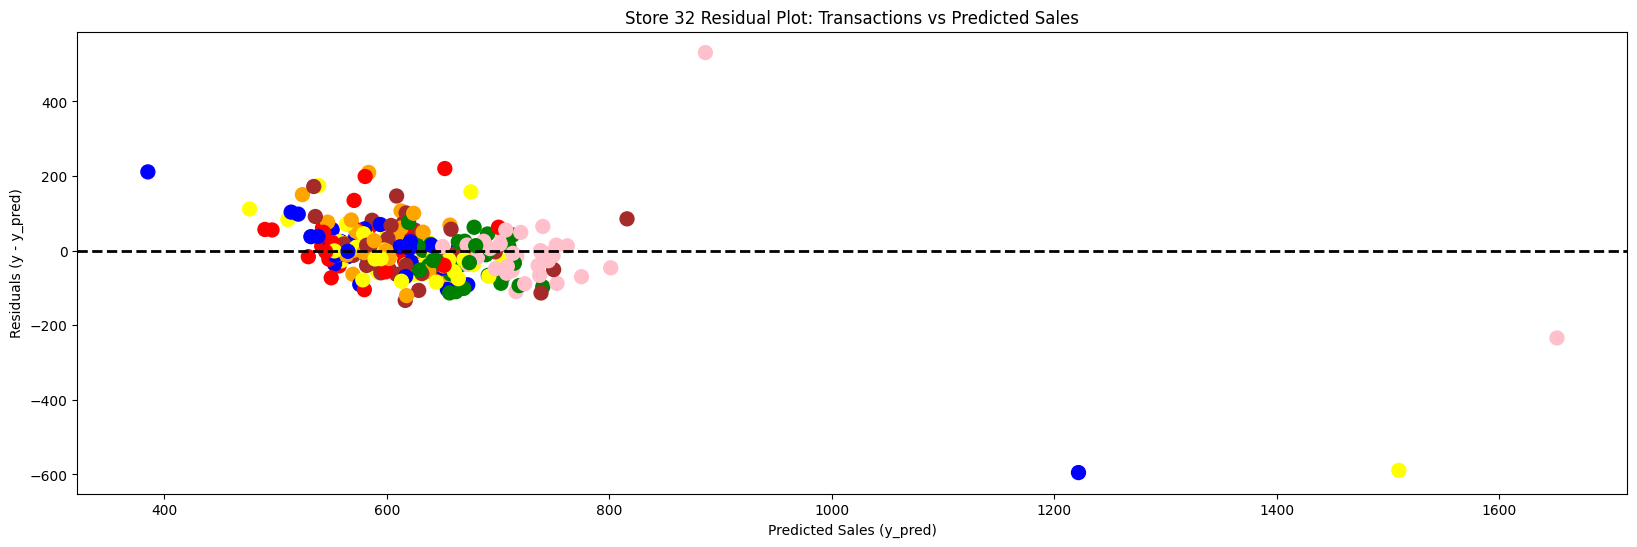

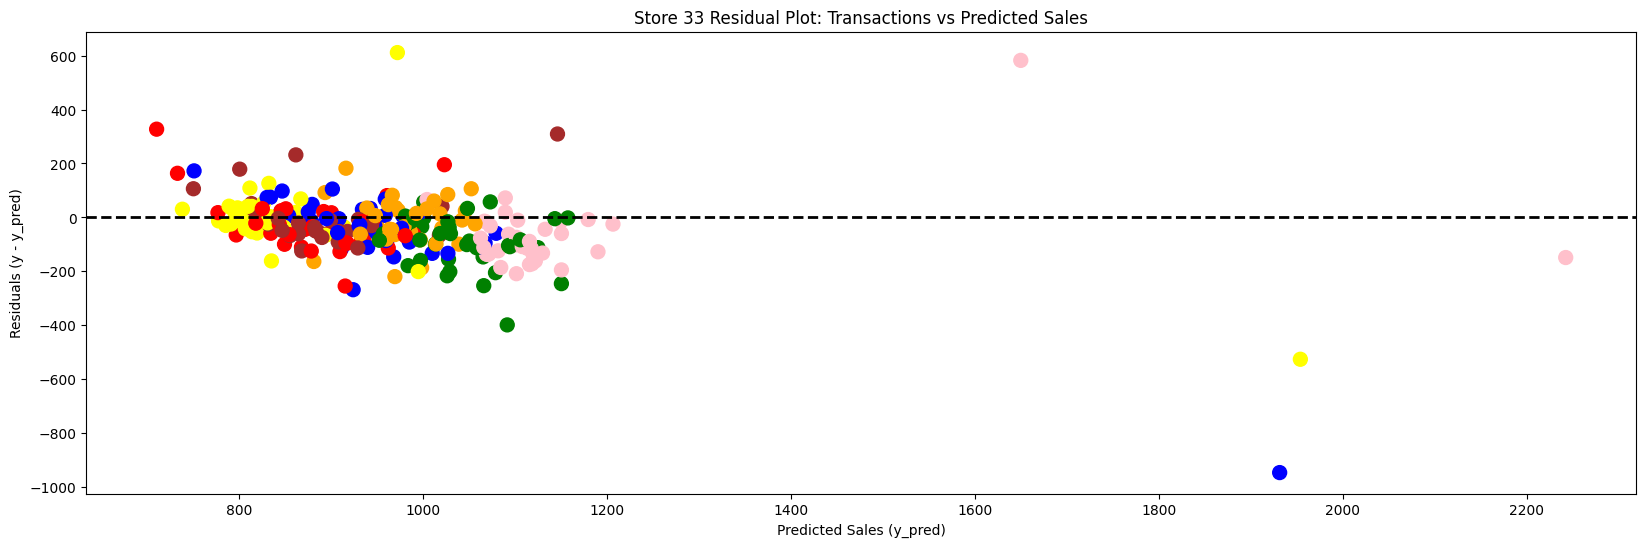

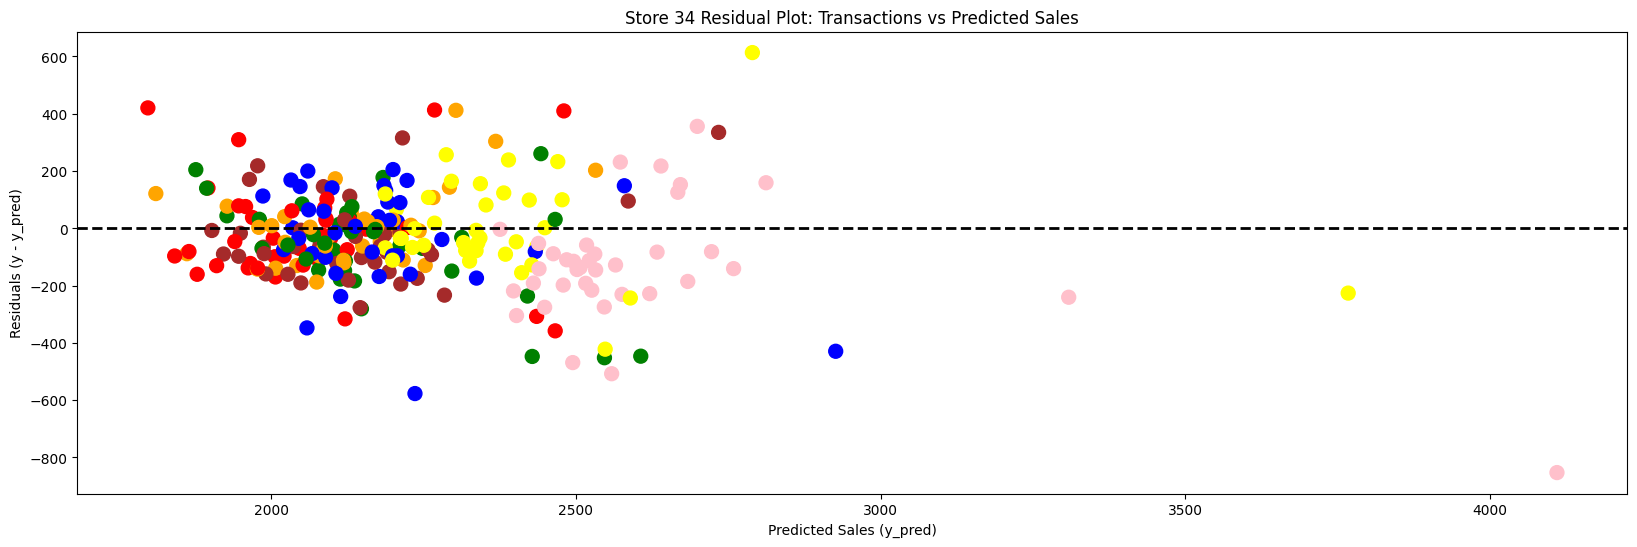

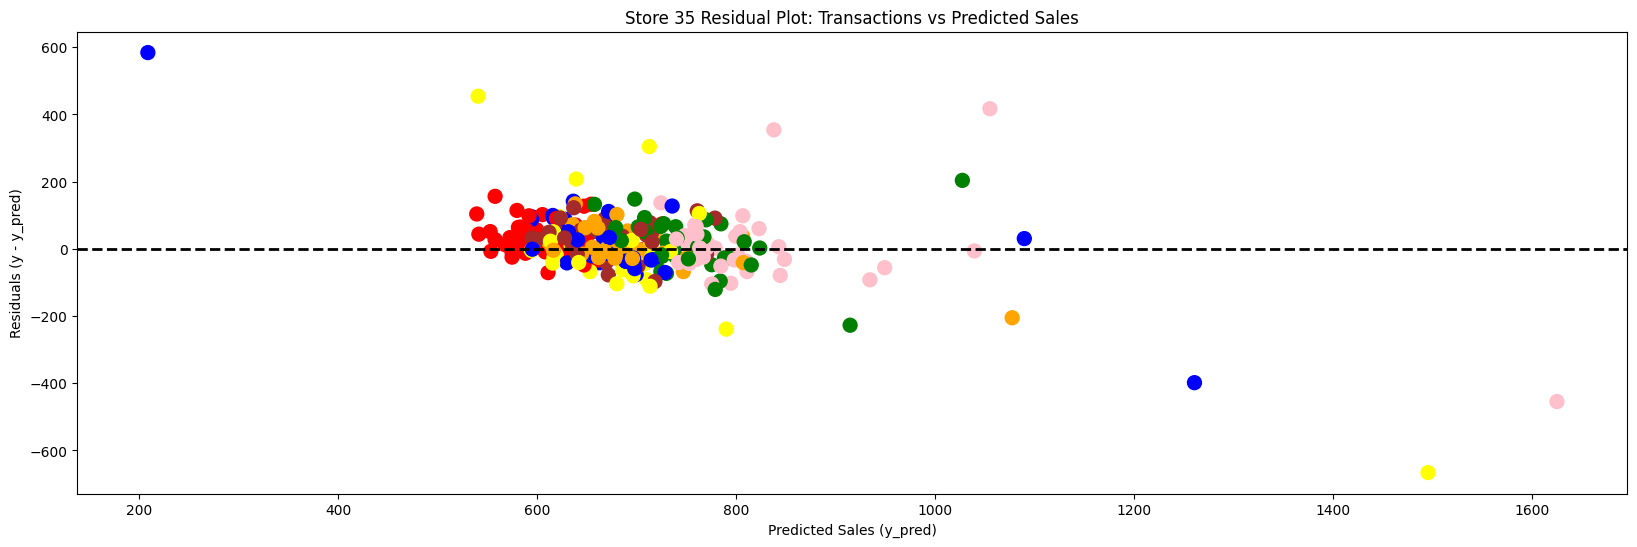

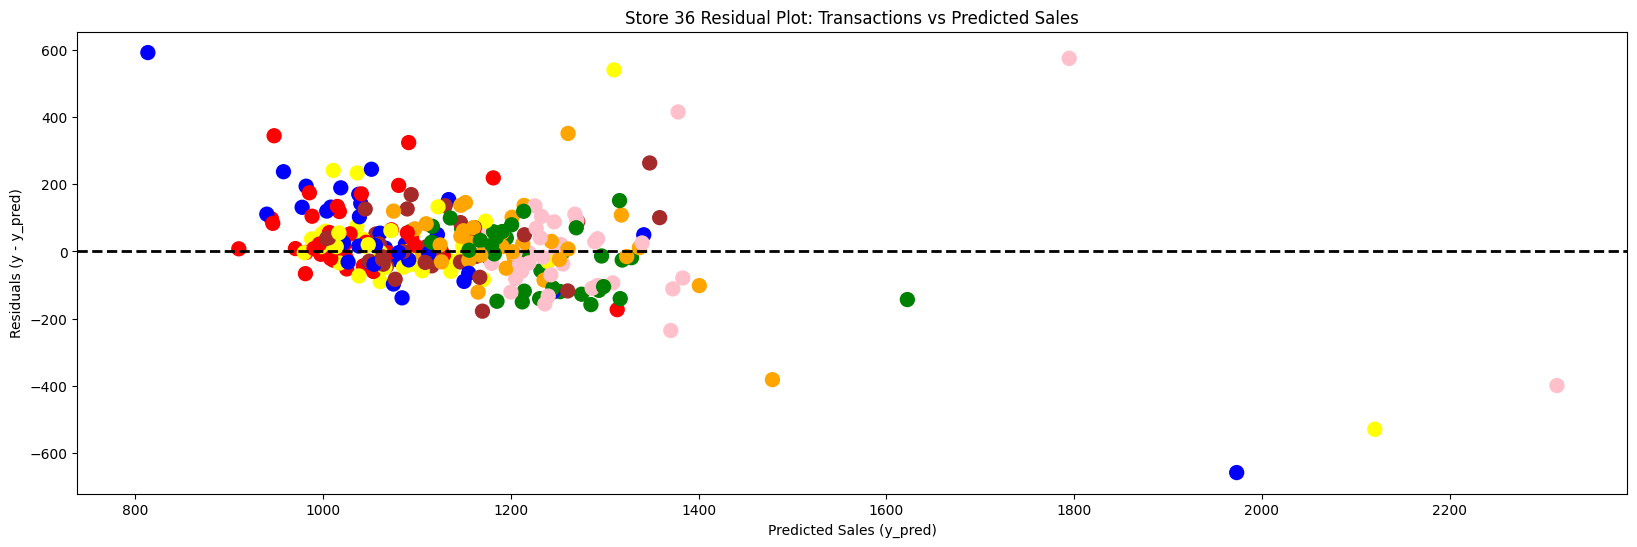

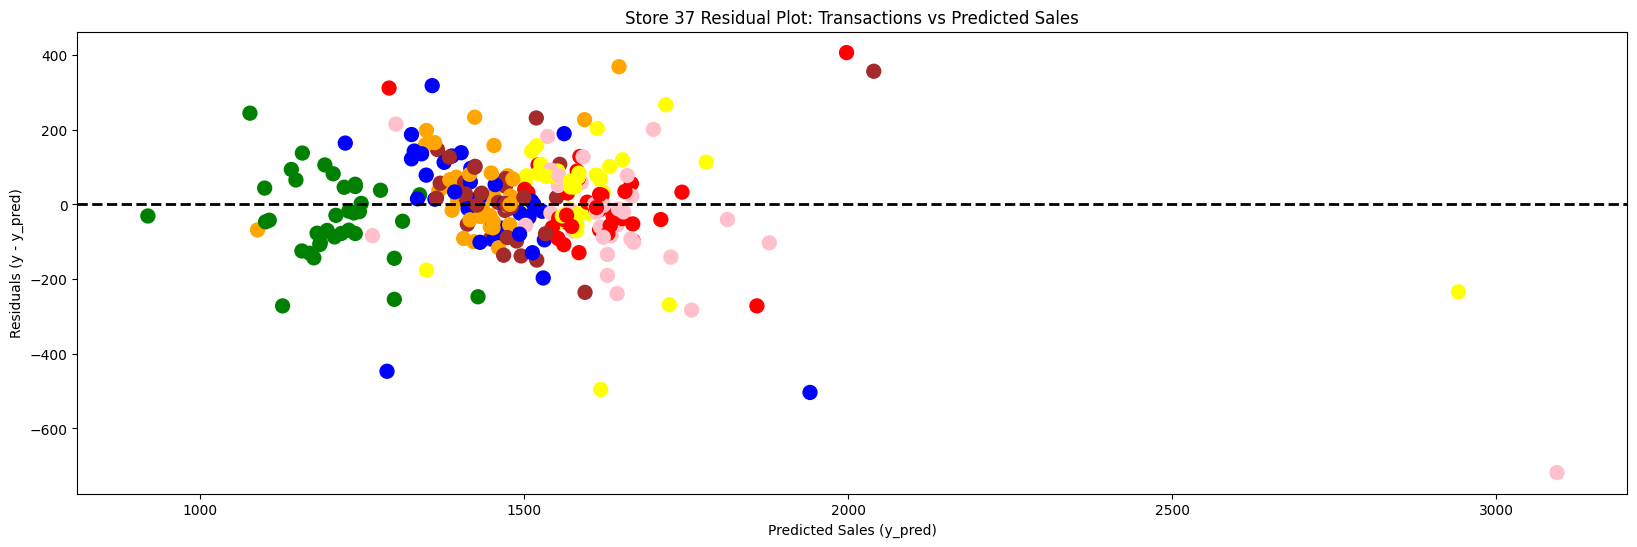

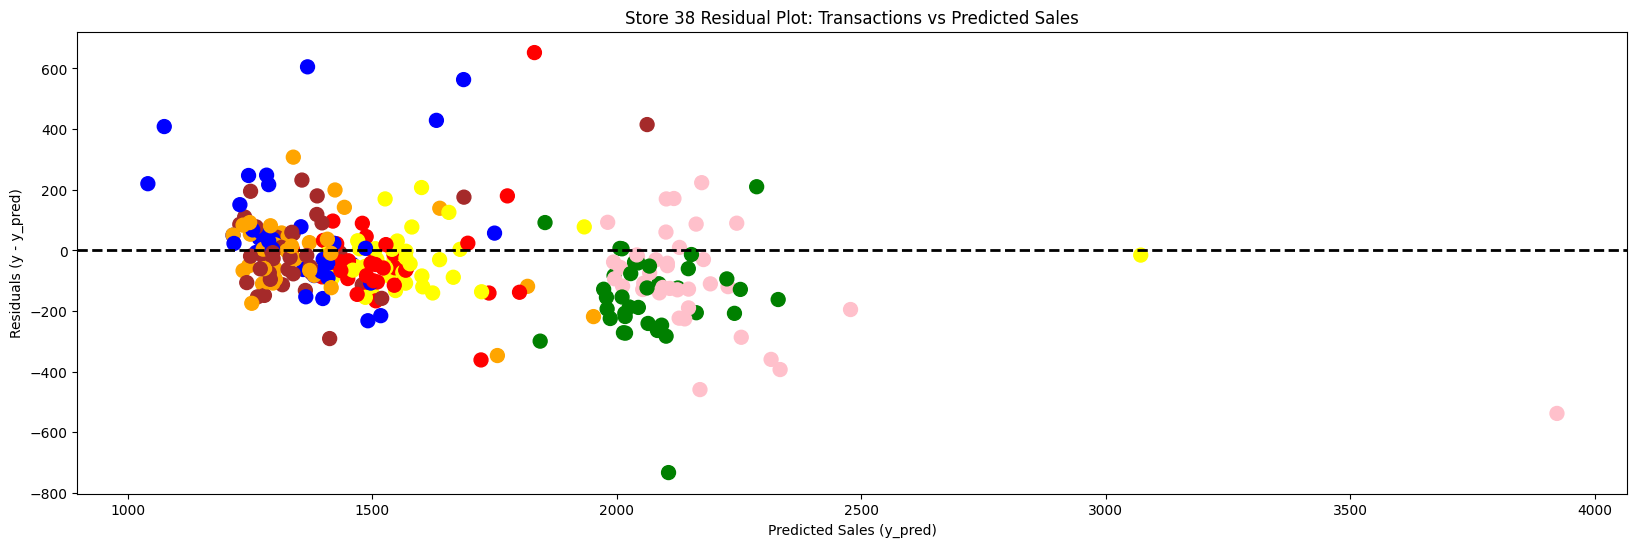

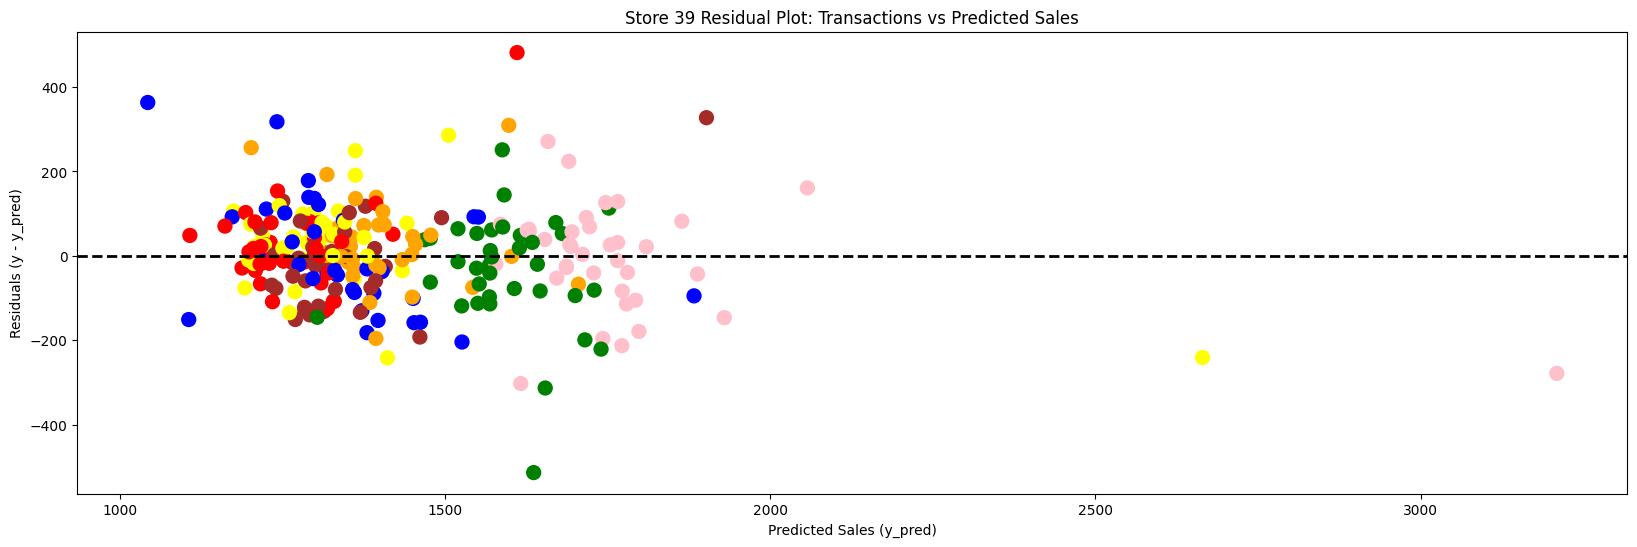

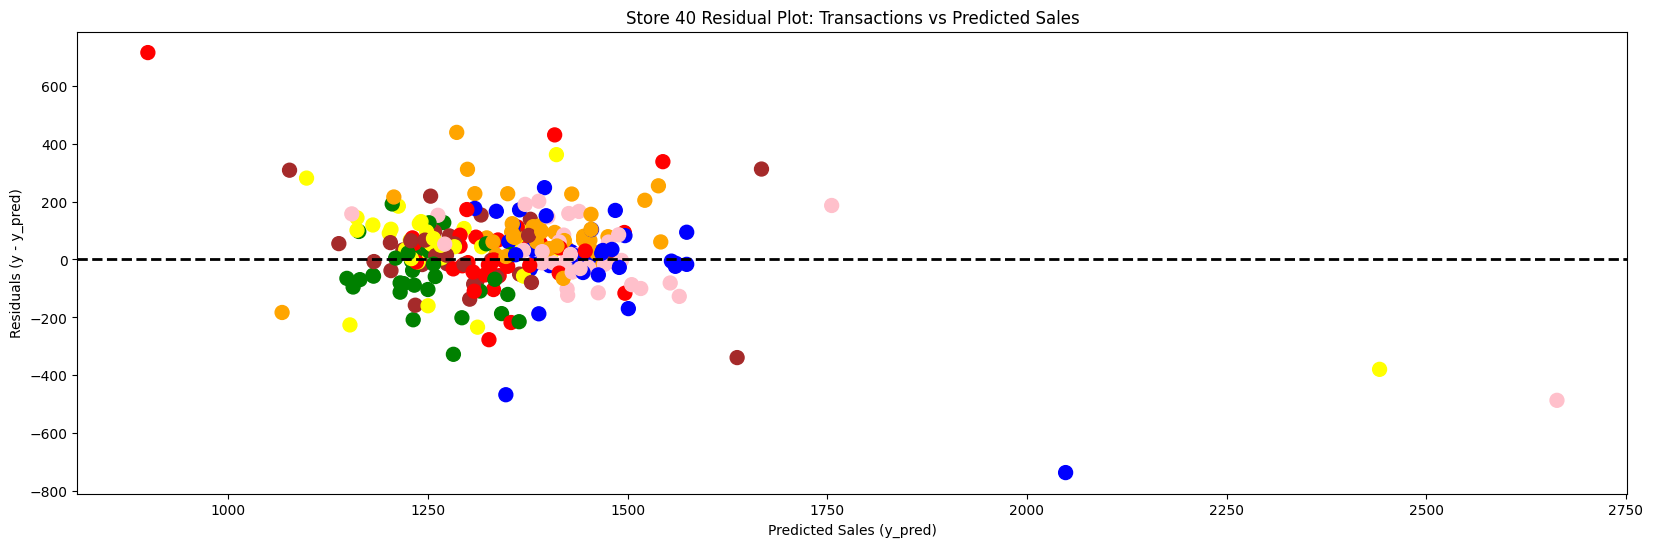

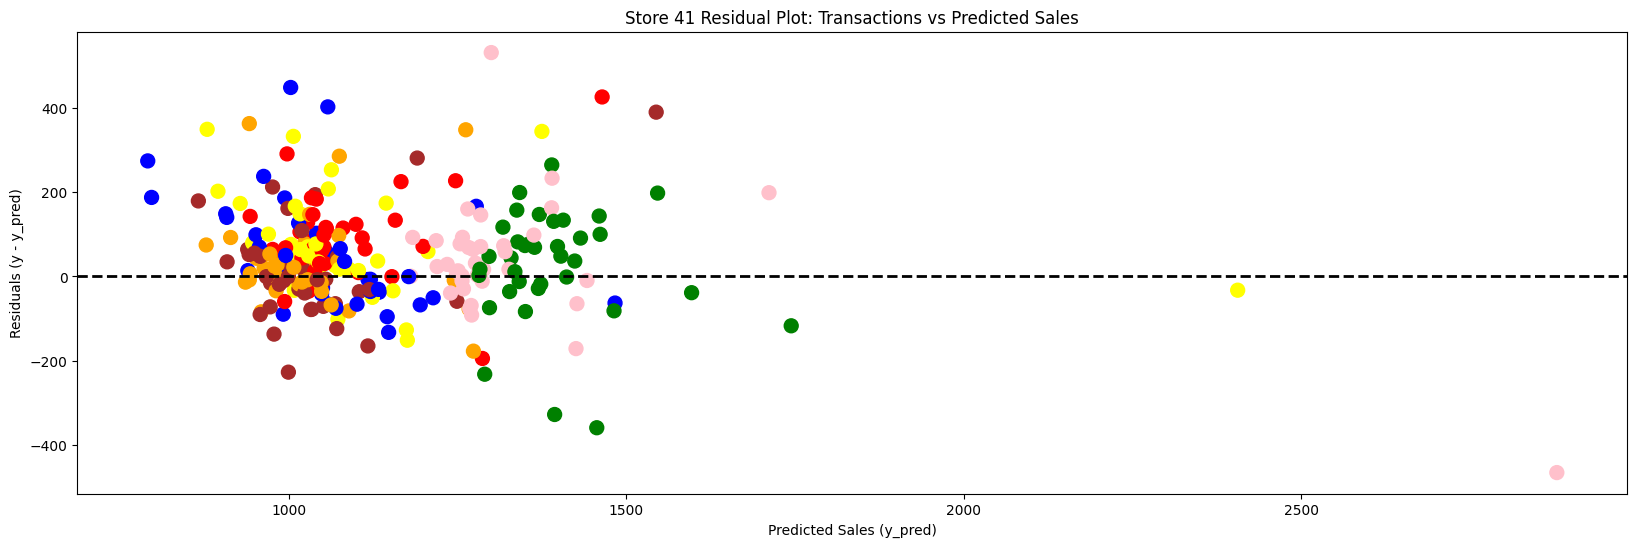

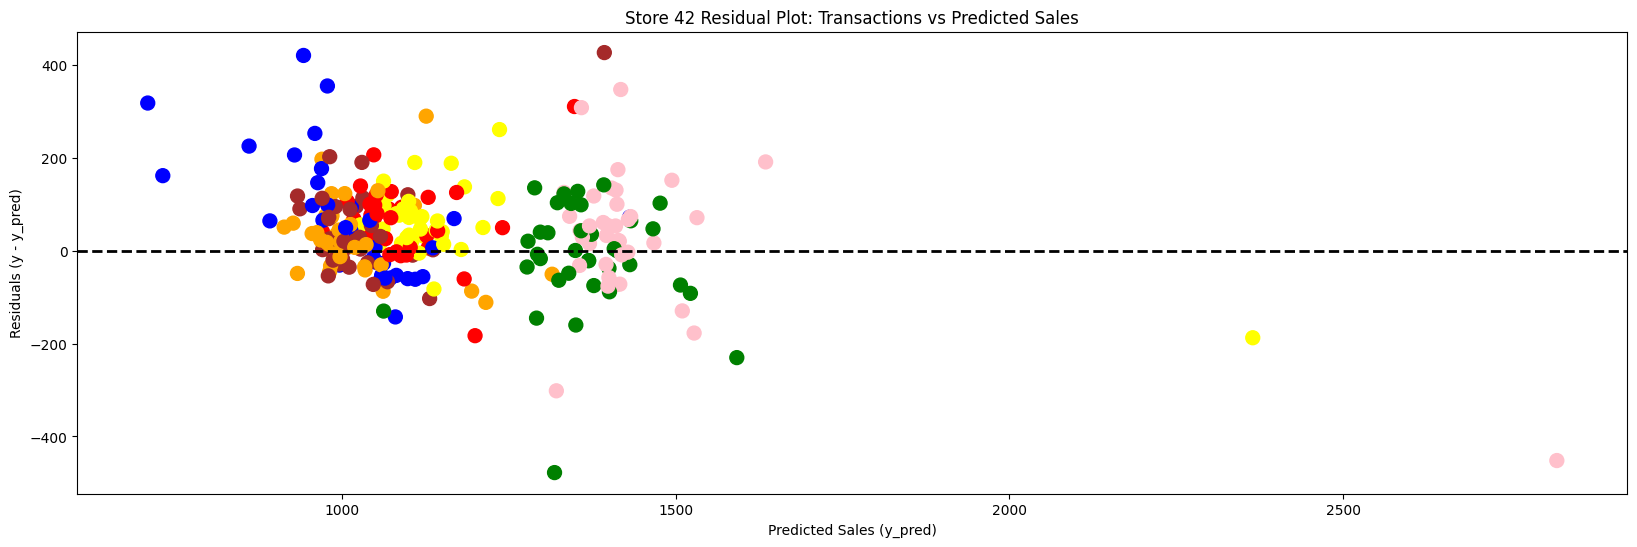

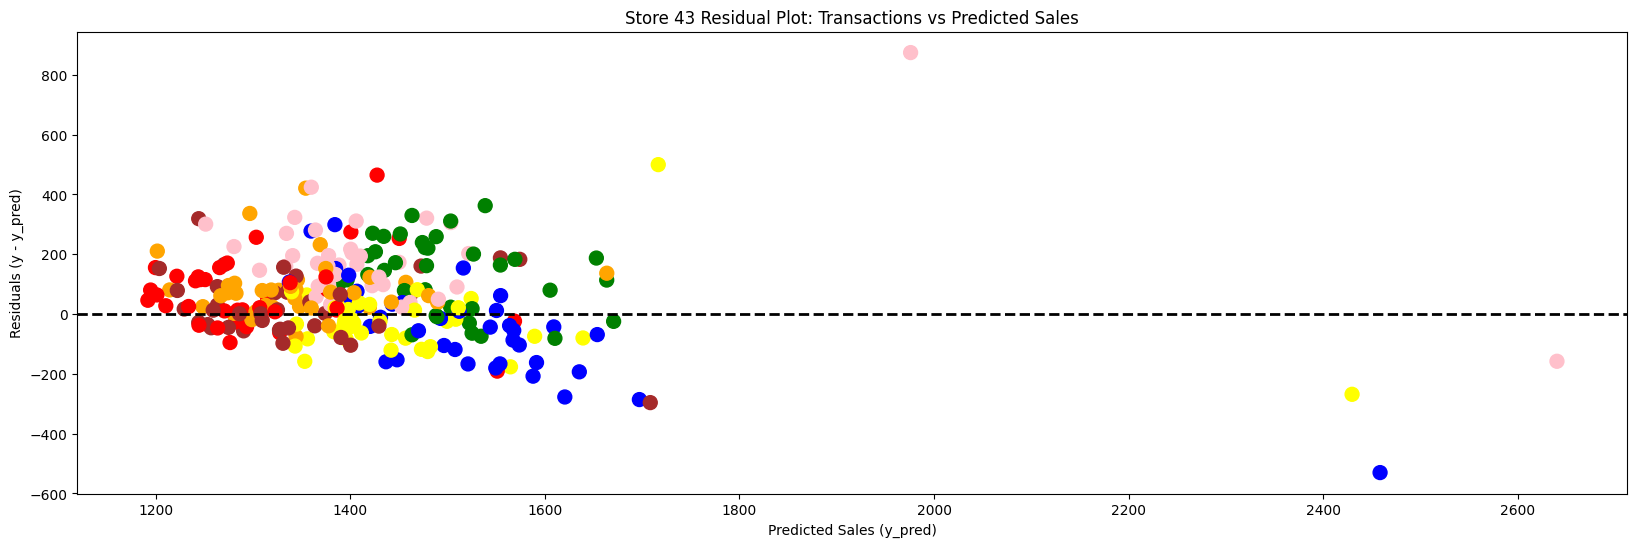

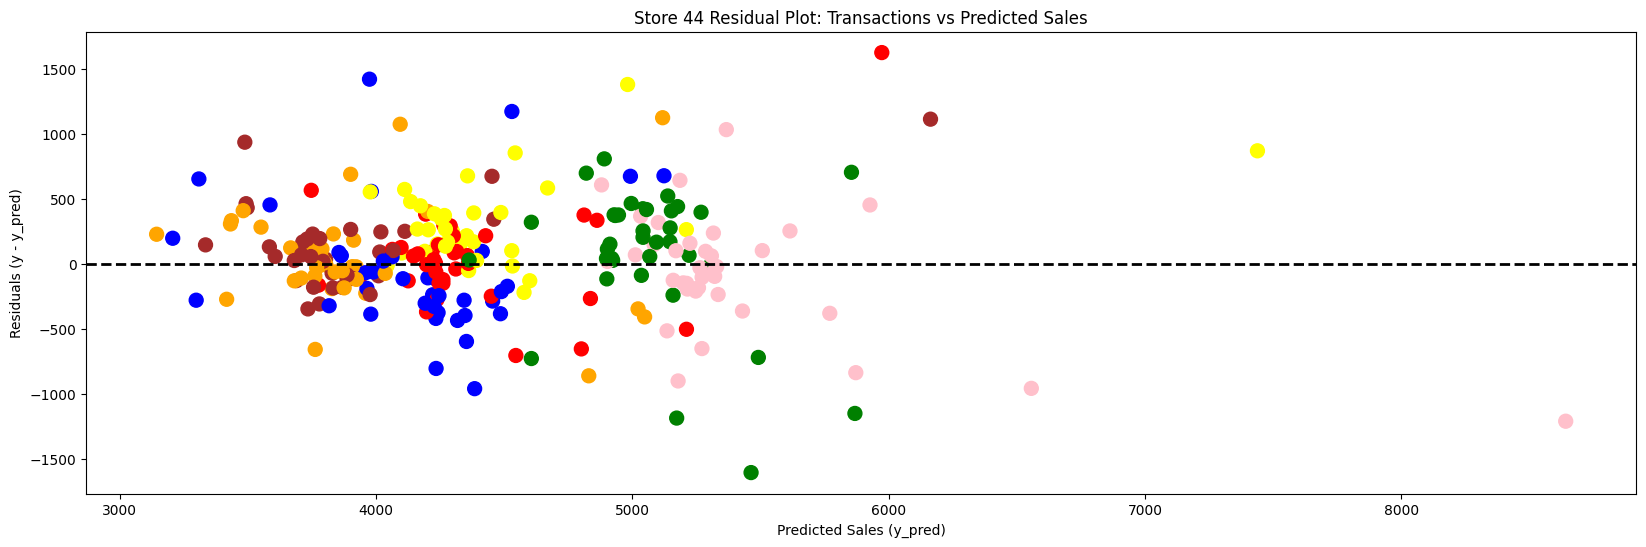

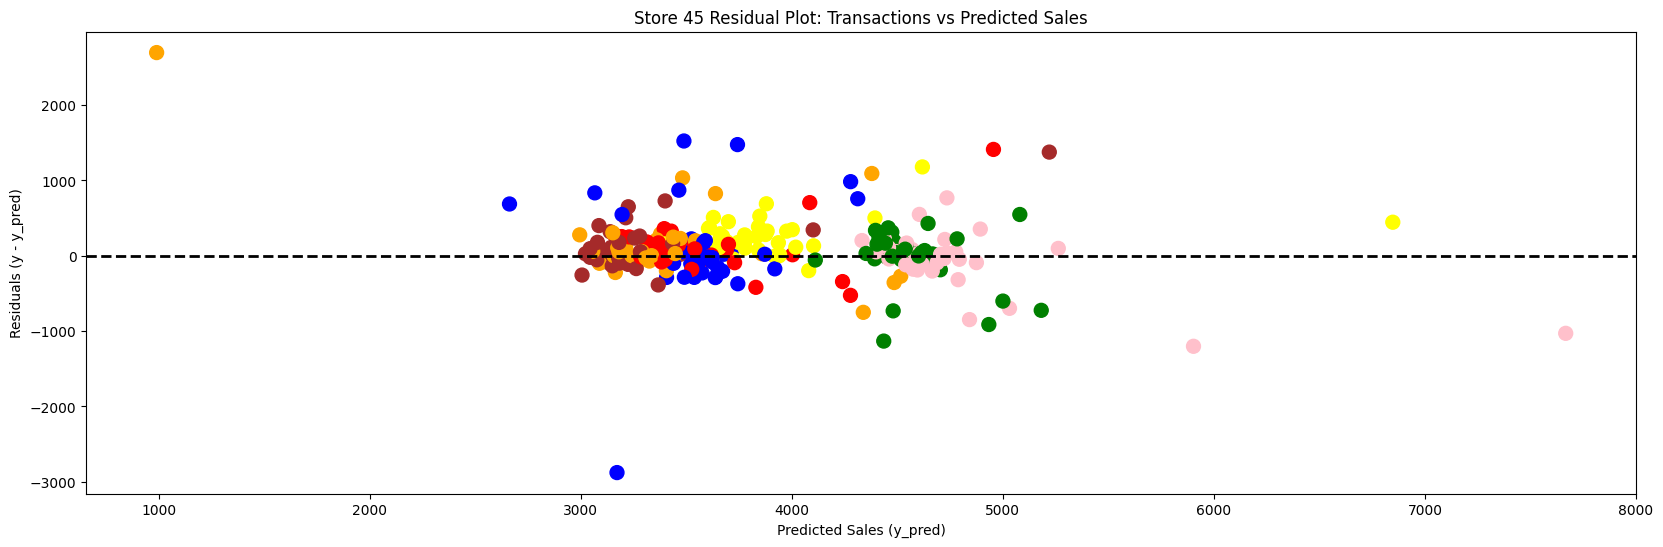

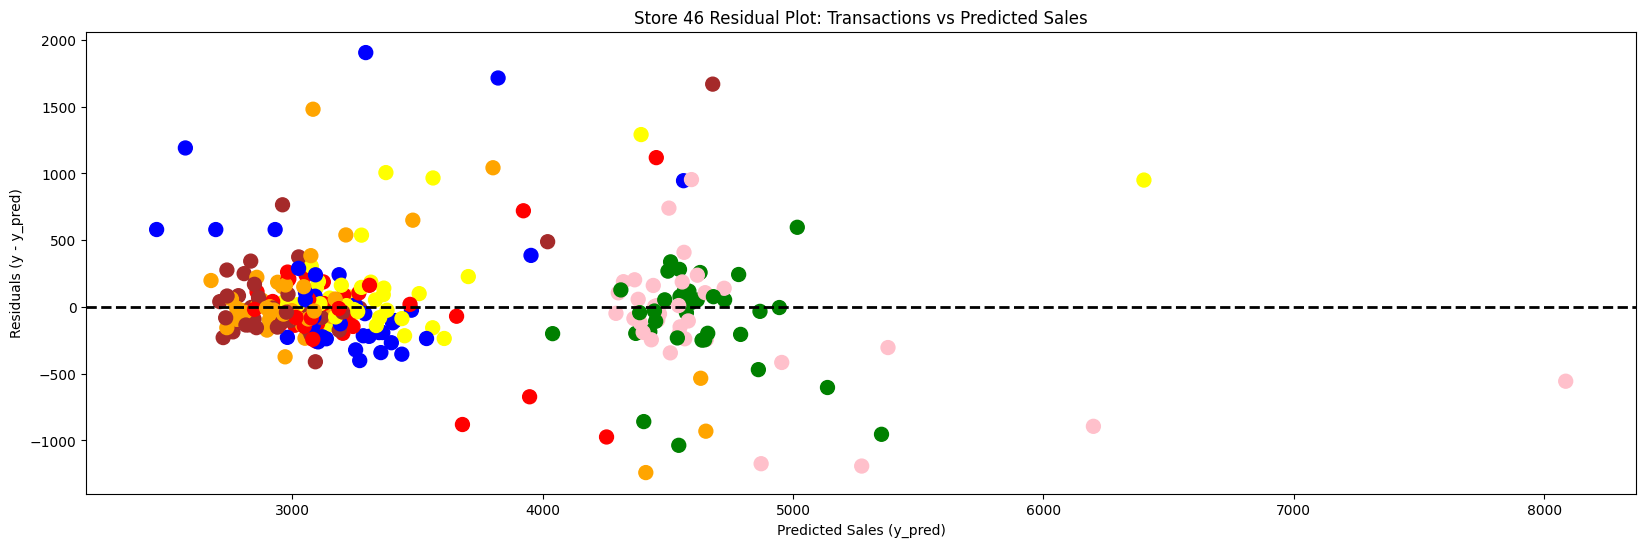

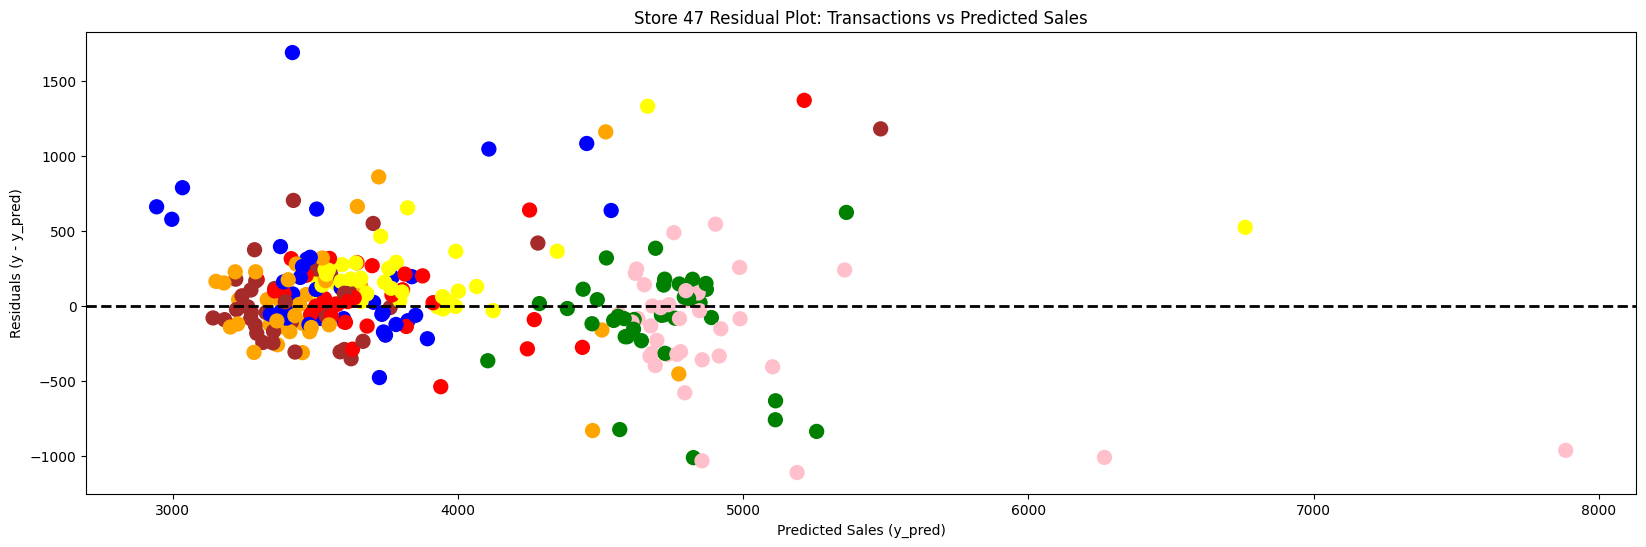

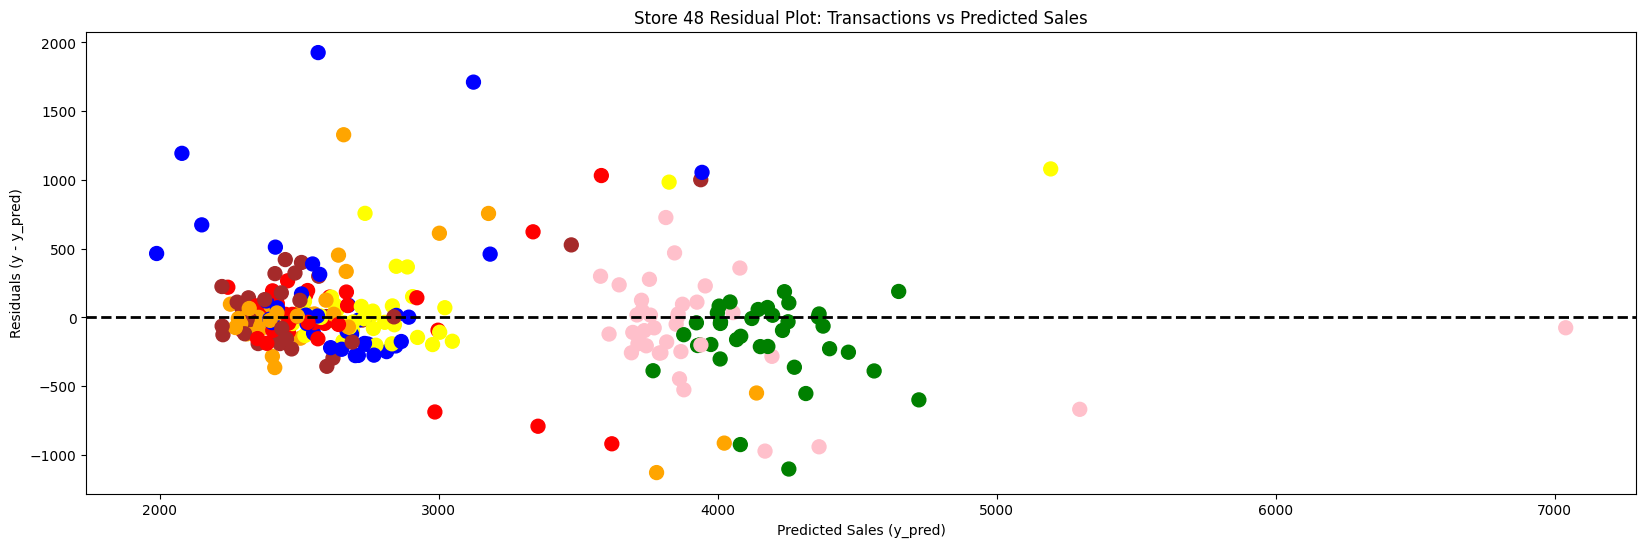

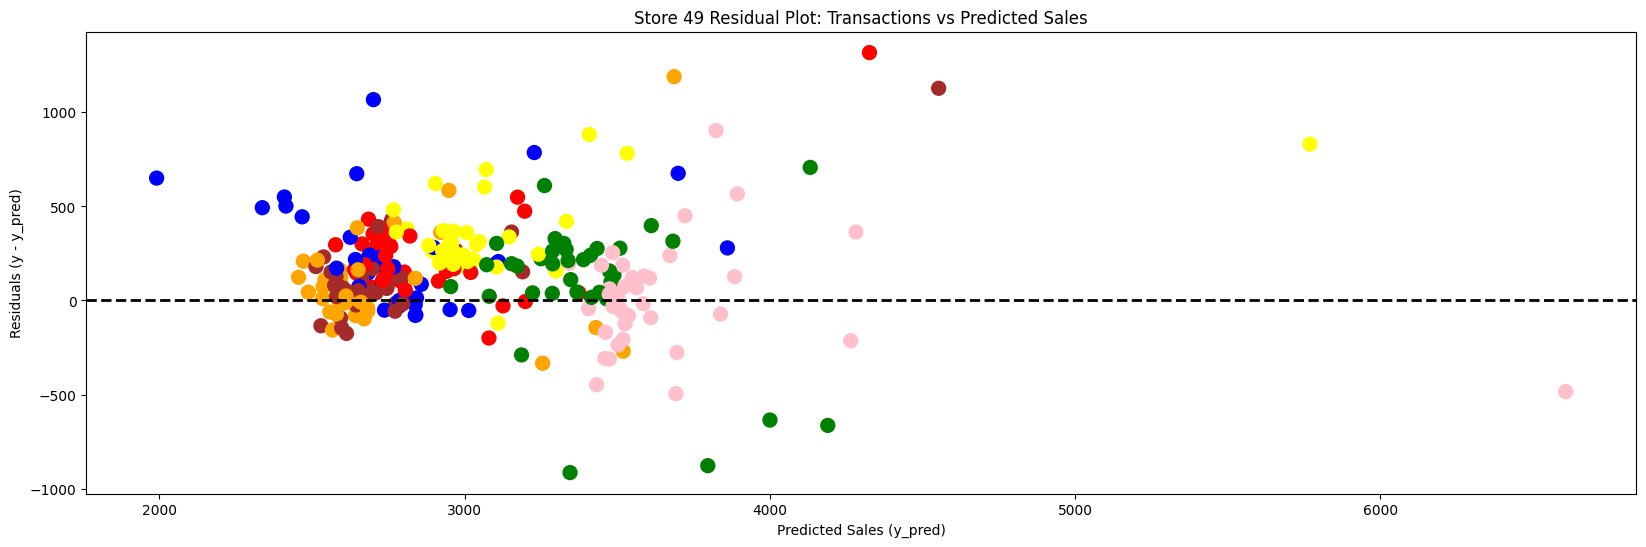

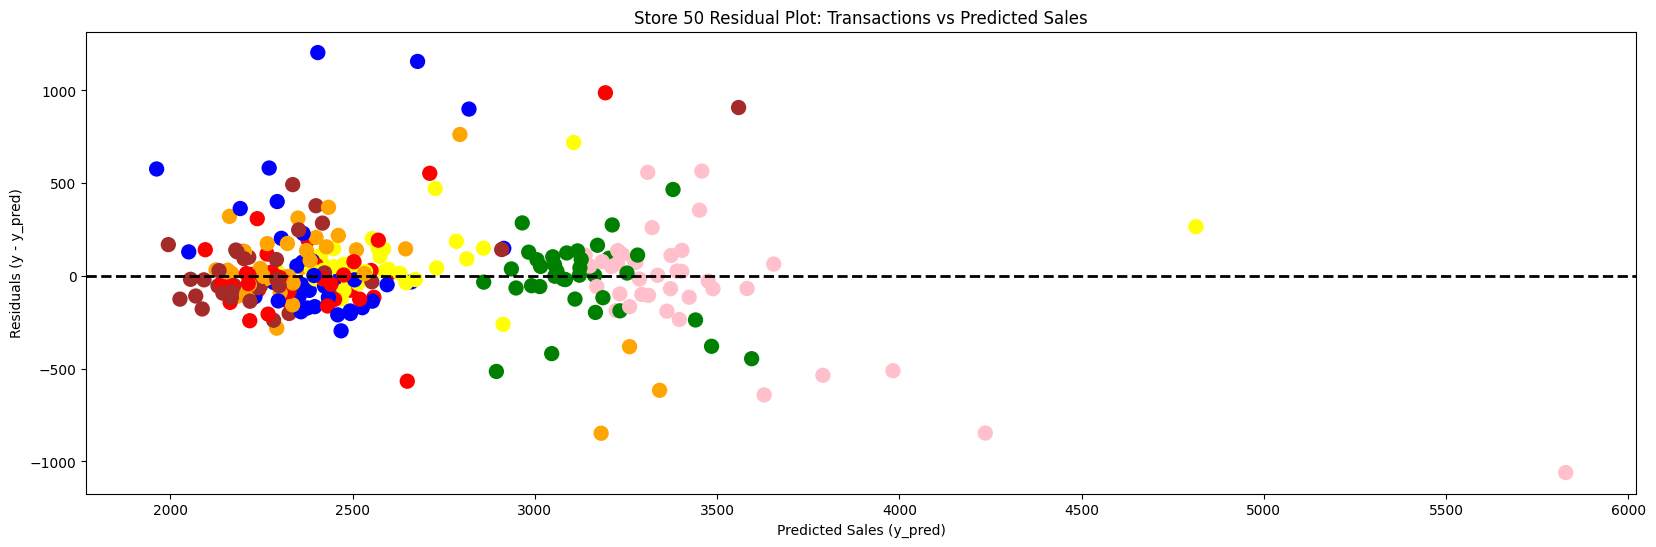

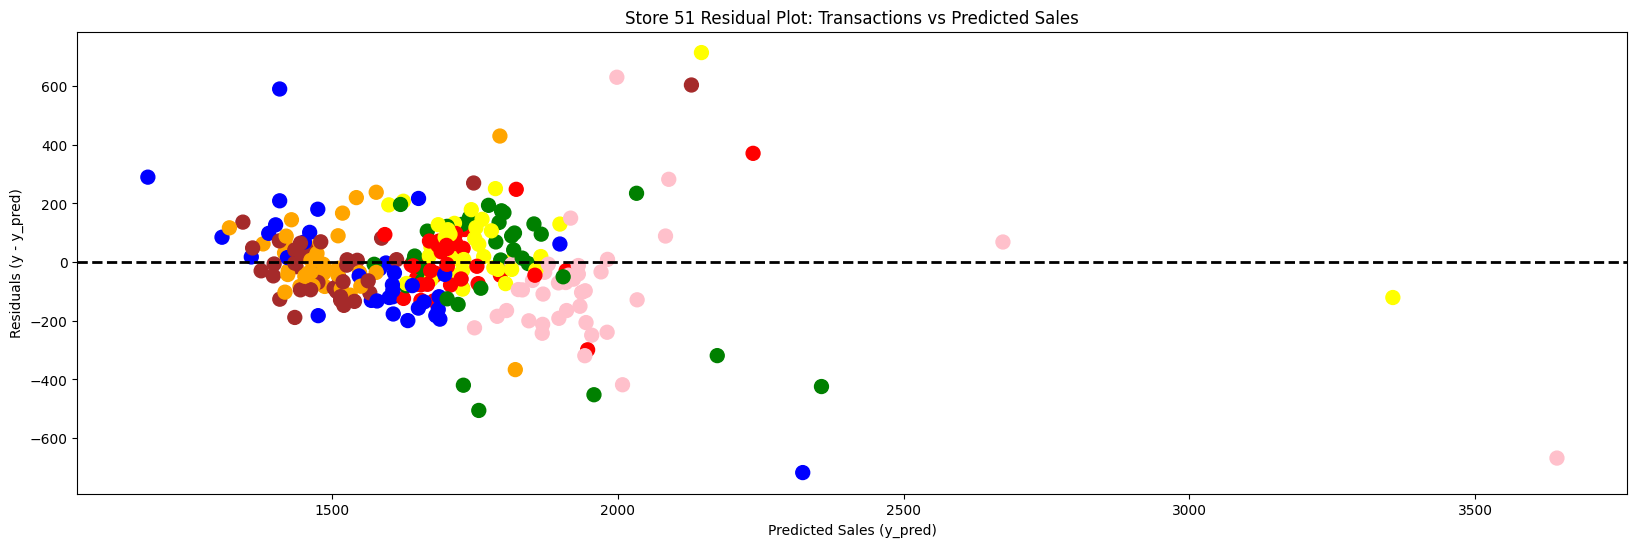

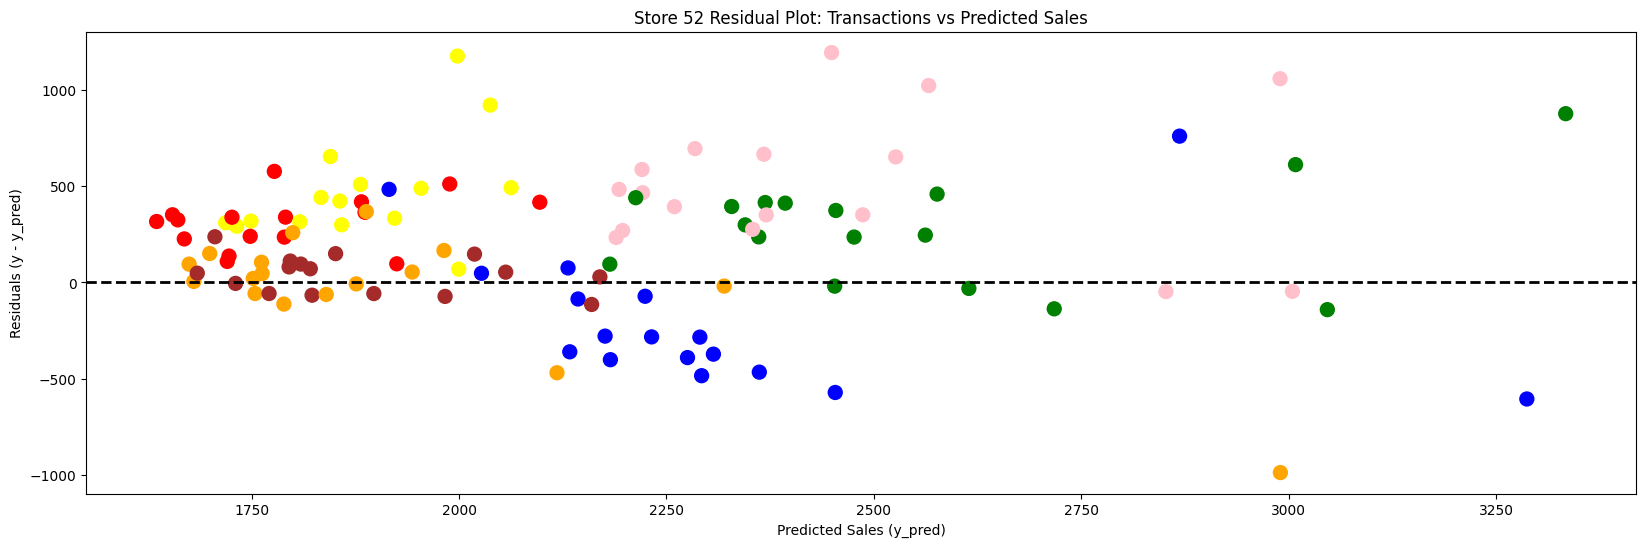

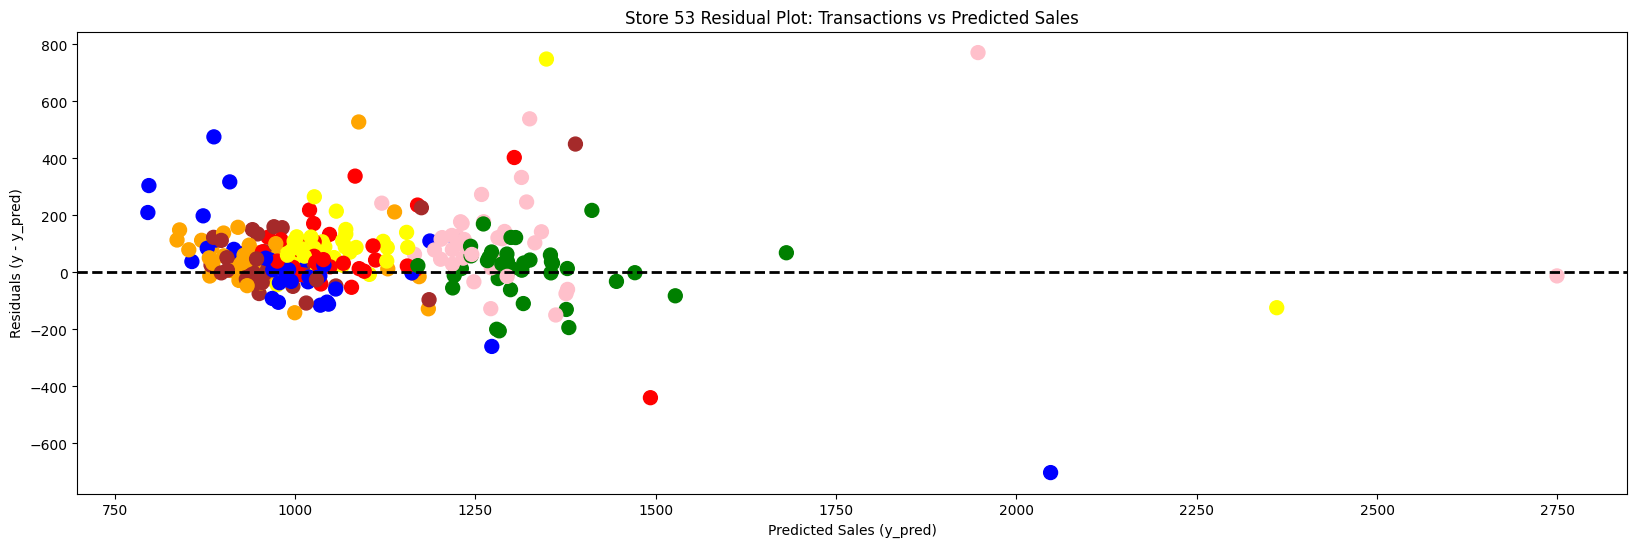

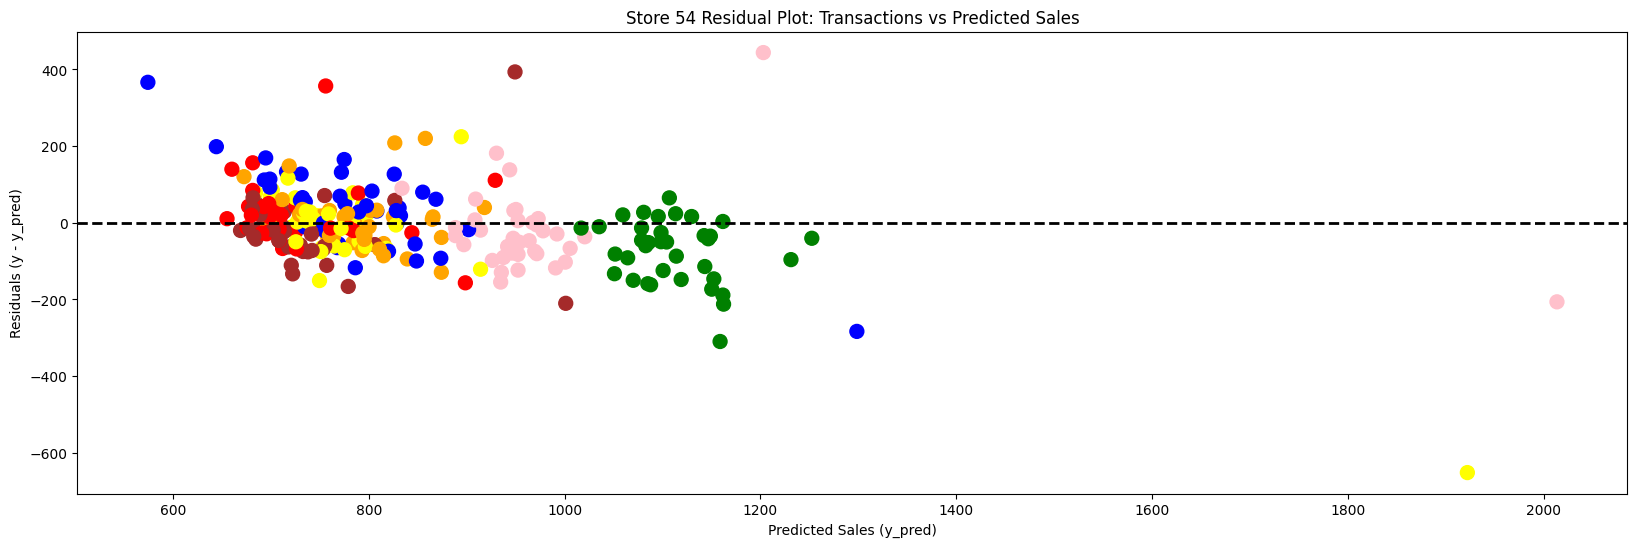

In [429]:
nbr = sorted(list(set(resid["store_nbr"].astype(int))))
nbr = list(map(str, nbr))
# Iterate over each store number and plot residuals
for i in nbr:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["store_nbr"] == i]
    
    # Plotting
    plt.figure(figsize=(20, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'Store {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

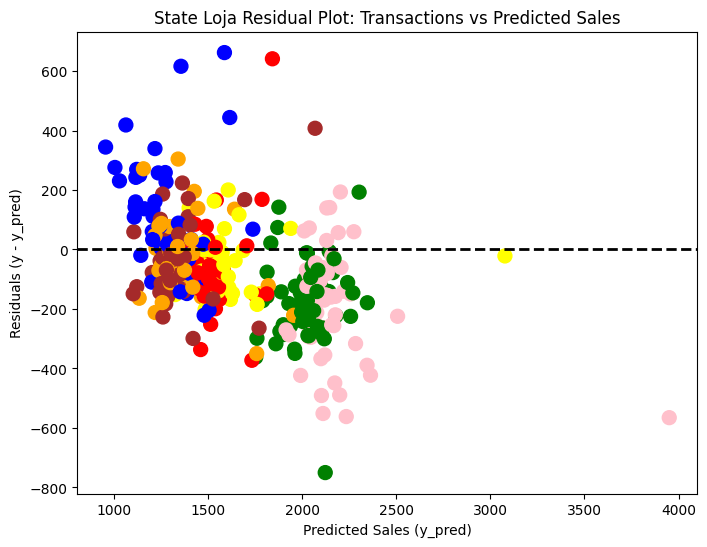

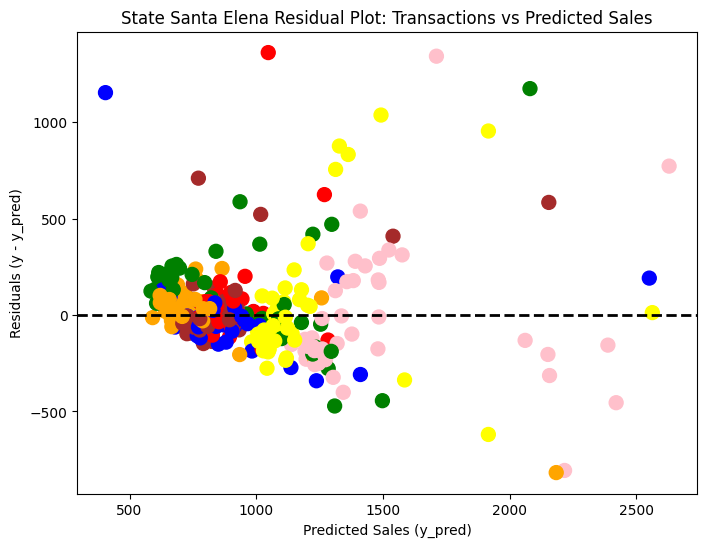

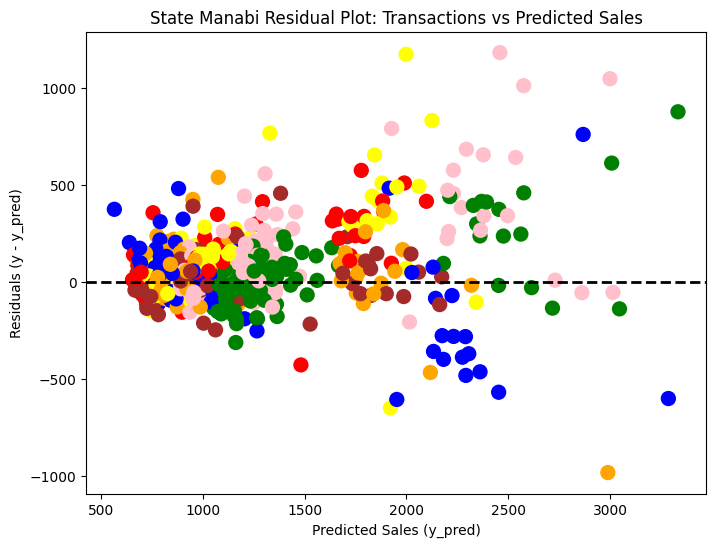

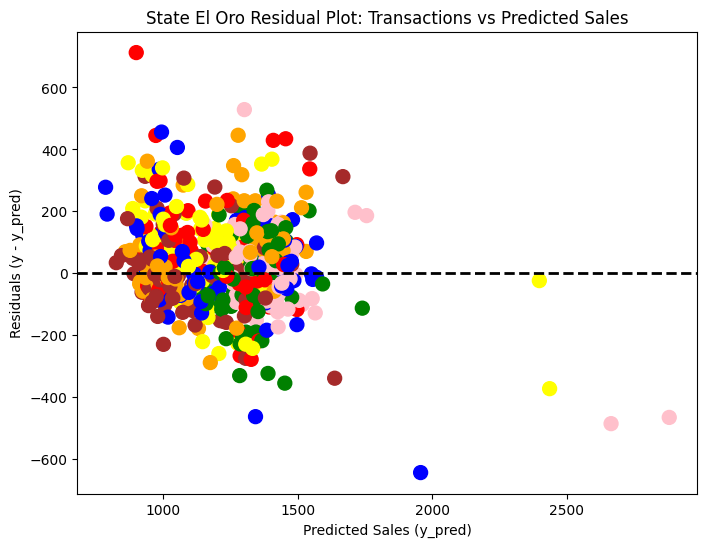

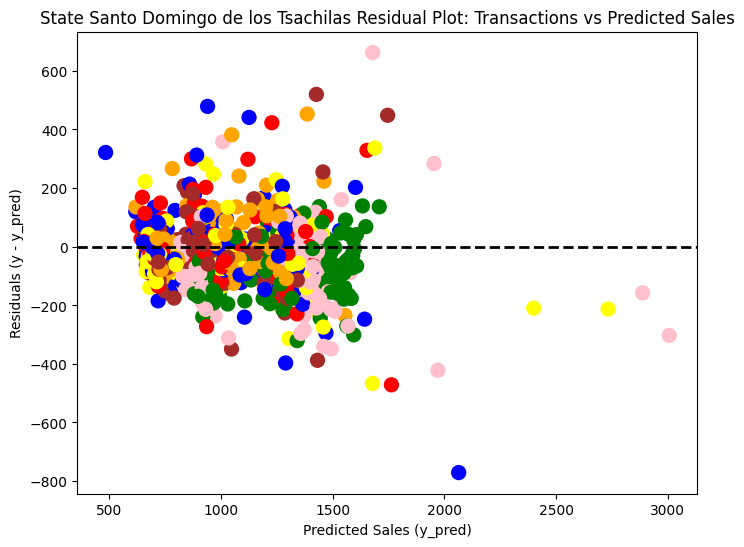

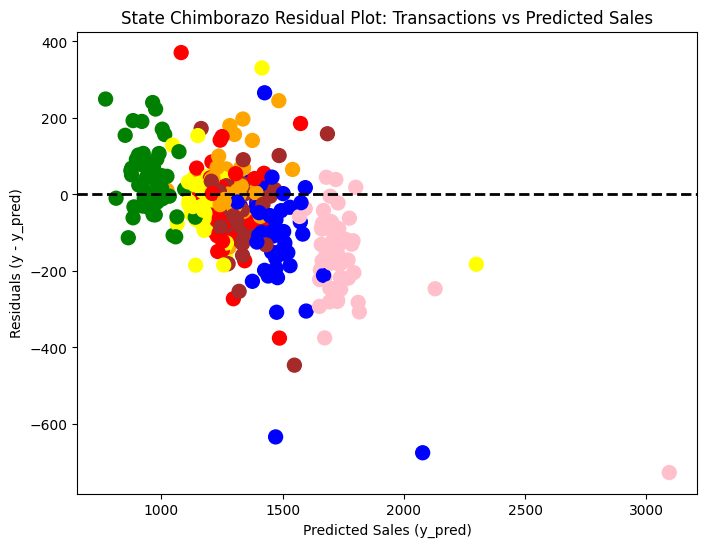

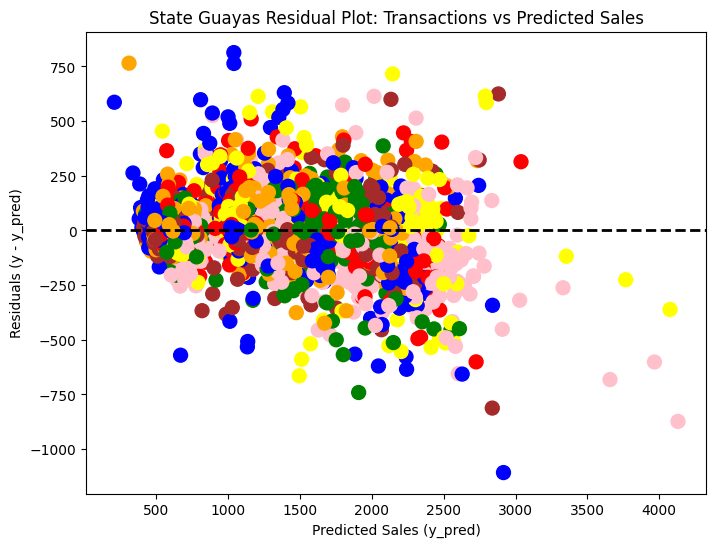

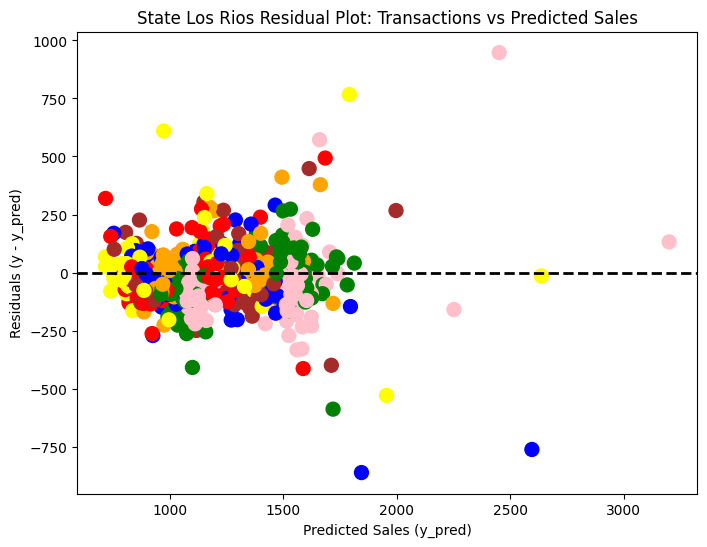

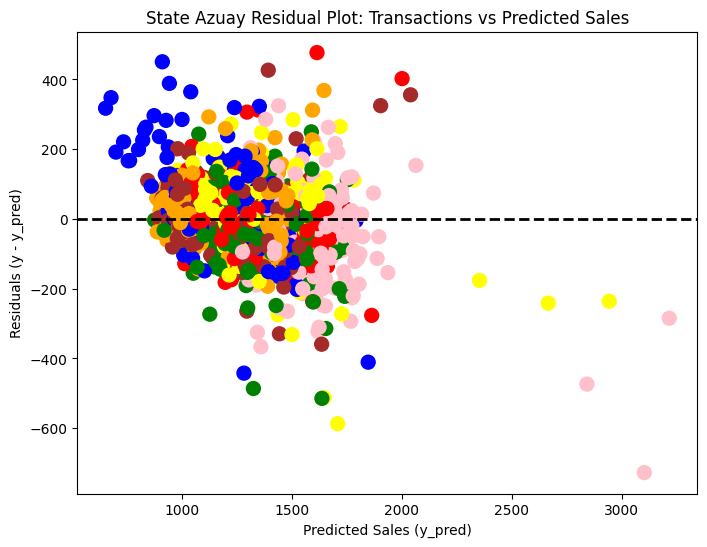

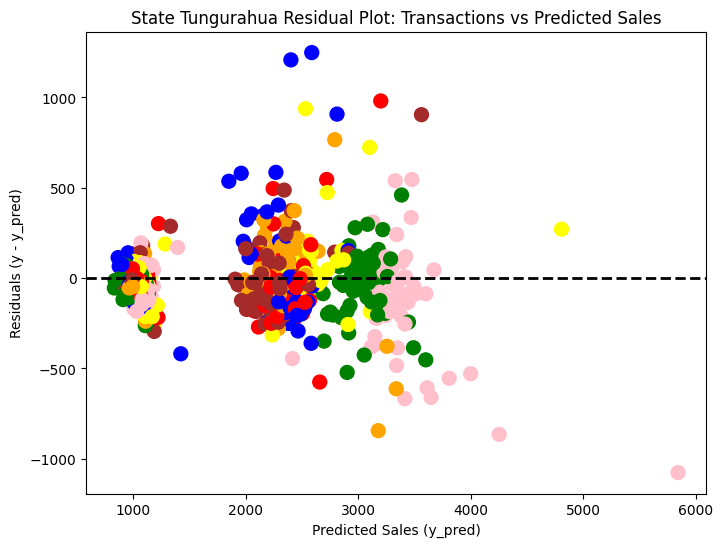

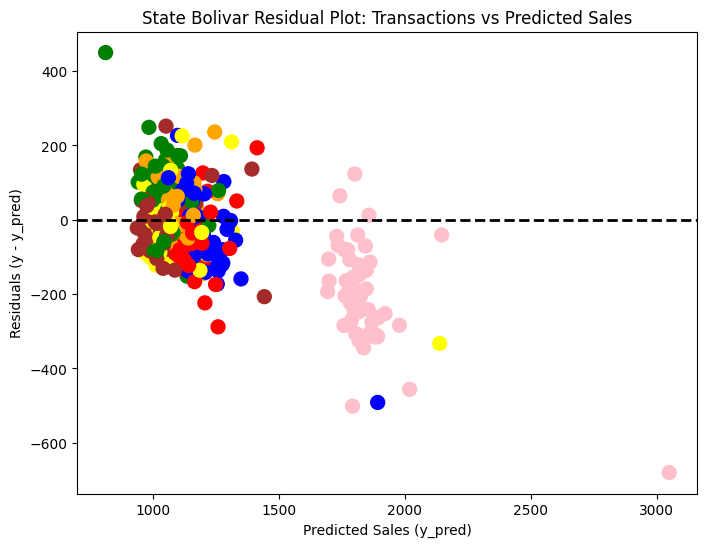

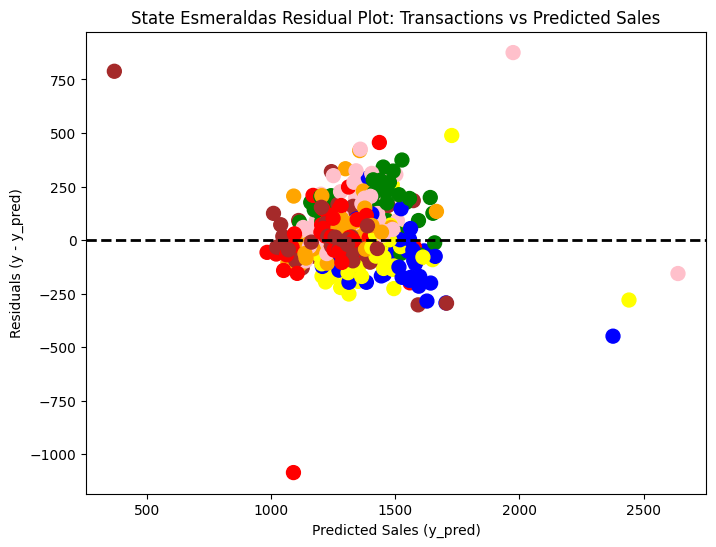

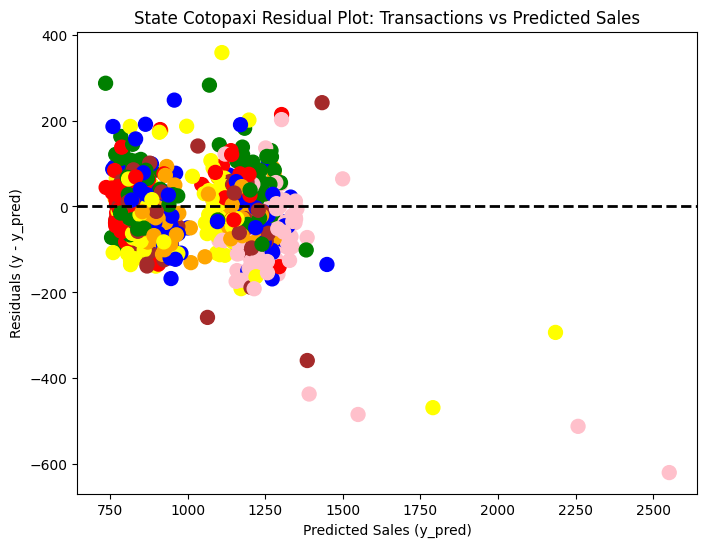

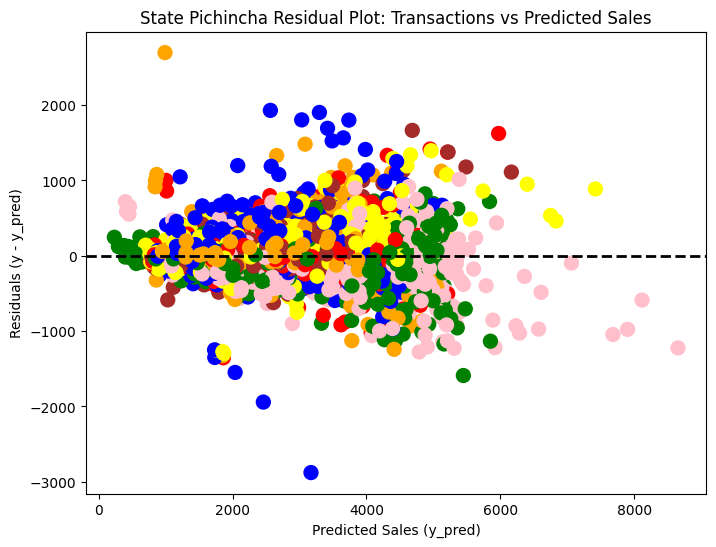

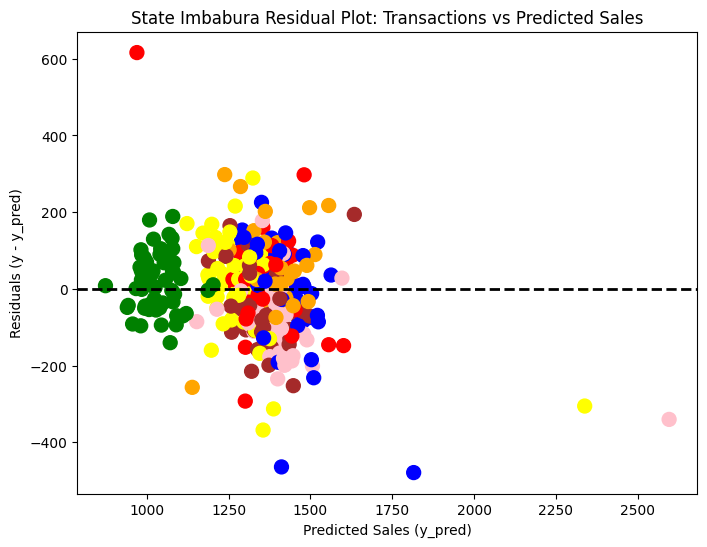

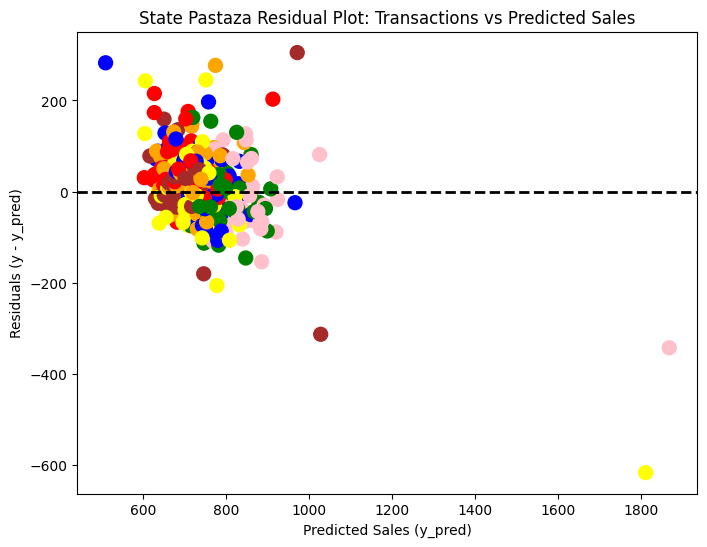

In [415]:
state = list(set(resid["state"]))
# Iterate over each store number and plot residuals
for i in state:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["state"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'State {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

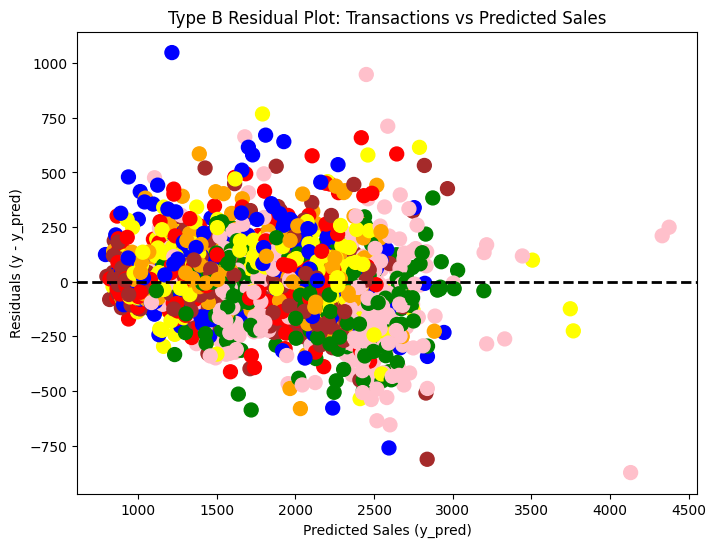

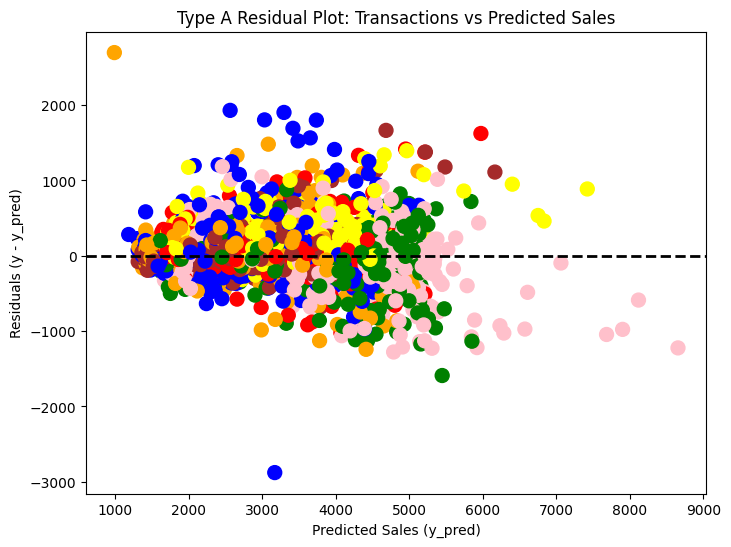

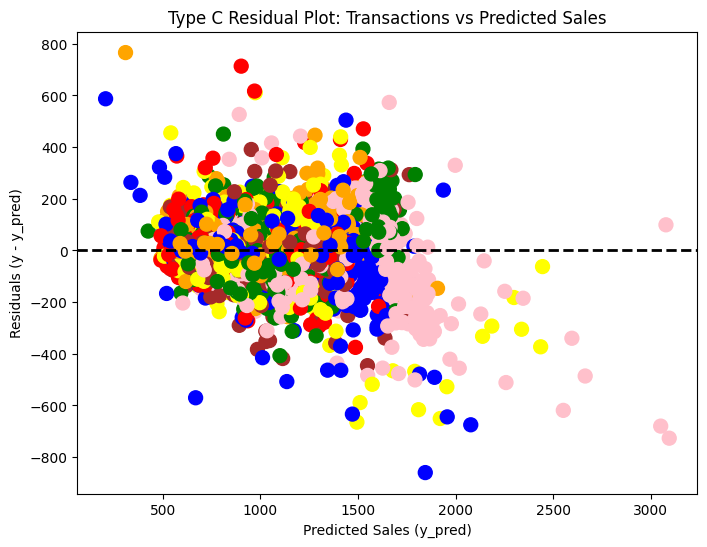

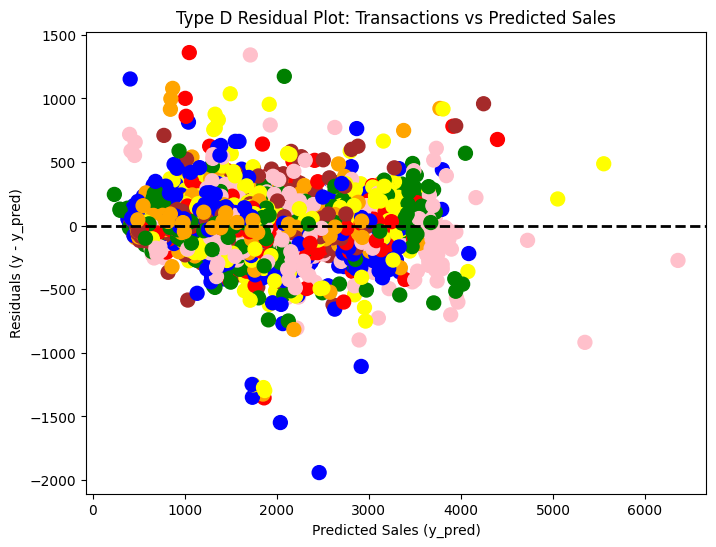

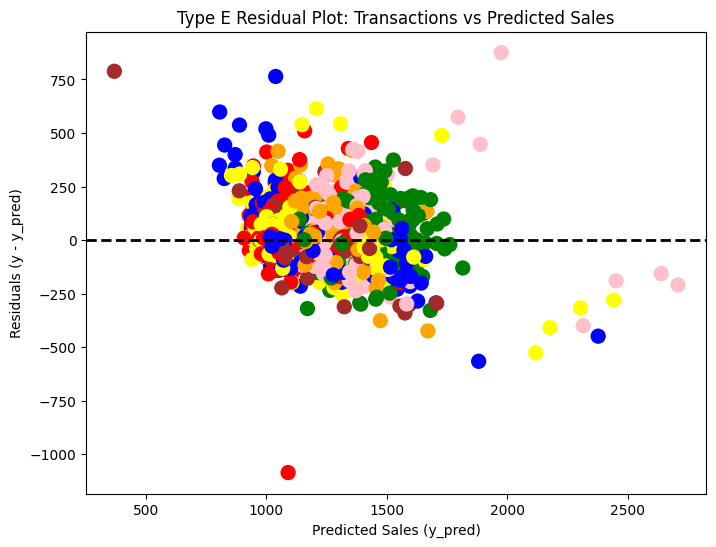

In [416]:
_type = list(set(resid["type"]))
# Iterate over each store number and plot residuals
for i in _type:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["type"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'Type {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()